<a href="https://colab.research.google.com/github/RishikaRishi17/gene-expression-feature-selection/blob/main/A_COMPARATIVE_STUDY_FEATURE_SELECTION_TECHNIQUES_FOR_IMPROVING_CLASSIFICATION_ACCURACY_ON_HIGH_DIMENSIONAL_DATASETS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Necessory Libraries and Mount GDrive**

In [1]:
# @title Default title text
#mount gdrive
from google.colab import drive

#file_path
import scipy.io

import pandas as pd
import numpy as np

#For scaling
from sklearn.preprocessing import StandardScaler

# To plot the graph
import matplotlib.pyplot as plt

#sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif, RFE, SelectFromModel

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

import seaborn as sns

from collections import Counter

#SHAP
import shap

# **MOUNT GOOGLE DRIVE**

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Creating Folder and storing dataset path

In [4]:
import os

# Detect if running in Google Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = "/content/drive/MyDrive/Feature_Selection_Project_2025/data/"
except ImportError:
    BASE_PATH = "./data/"

file_path = os.path.join(BASE_PATH, "SMK_CAN_187.mat")
data = scipy.io.loadmat(file_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file_path = "/content/drive/MyDrive/Feature_Selection_Project_2025/data/SMK_CAN_187.mat"
data = scipy.io.loadmat(file_path)

# **Extract Features and Labels**

In [5]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'X'])


In [6]:
# X is the data matrix (features), shape: (187, 19993)
X = pd.DataFrame(data['X'])

In [7]:
# Flatten Y properly to get shape (187,)+
Y = pd.Series(data['Y'].flatten().astype(int))

In [8]:
# mapping the target values 1s in to 0s and 2s in to 1s - 0
# 1 => Cancer, 0 => Non-Cancer
Y = Y.map({1: 0, 2: 1})

In [9]:
X['label'] = Y

In [10]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (187, 19994)
Y shape: (187,)


In [11]:
print(set(Y))

{0, 1}


In [12]:
print("Label distribution:", np.bincount(Y.astype(int)))  # Count of 0s and 1s

Label distribution: [90 97]


In [13]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,19984,19985,19986,19987,19988,19989,19990,19991,19992,label
0,10.697,5.345,7.142,4.814,6.948,6.704,8.101,7.175,7.753,6.138,...,5.783,8.114,7.373,5.467,5.103,5.500,5.209,7.569,6.748,0
1,10.424,5.463,7.246,5.098,5.946,6.795,8.260,7.395,7.823,5.915,...,6.532,8.254,7.514,5.759,5.337,5.732,4.215,8.010,6.859,0
2,10.374,5.482,7.815,4.935,6.463,6.772,8.410,7.510,8.013,6.273,...,6.503,8.594,8.052,5.968,5.619,6.601,4.249,8.144,6.928,0
3,10.500,5.584,7.404,5.140,5.764,6.999,8.433,7.568,7.591,5.830,...,6.571,8.304,7.576,5.366,5.491,5.776,4.582,7.526,6.966,0
4,9.820,5.612,7.511,5.263,5.562,6.713,8.312,7.464,7.704,5.550,...,6.761,8.693,8.326,6.438,5.280,5.735,4.619,8.983,7.247,0


In [14]:
count = (X.label == 0).sum()
print(count)

90


In [15]:
count = (X.label == 1).sum()
print(count)

97


# **Clean and Prepare the Data**

In [16]:
# Check for missing values
print(X.isnull().sum().sum())

0


In [17]:
# Separate features and labels
features = X.drop('label', axis=1)
labels = X['label']


In [18]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

In [19]:
# Final cleaned dataset
df = pd.DataFrame(X_scaled)
df['label'] = labels
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,19984,19985,19986,19987,19988,19989,19990,19991,19992,label
0,0.966438,0.059834,0.298827,0.063764,0.650560,0.200938,0.339300,0.198288,0.742193,0.511111,...,0.086400,0.182428,0.074843,0.396459,0.293715,0.331263,0.797493,0.237220,0.252142,0
1,0.872945,0.129739,0.370600,0.284603,0.416667,0.236513,0.463035,0.355207,0.793028,0.387222,...,0.485867,0.276325,0.163522,0.553112,0.439328,0.451346,0.141821,0.413339,0.320073,0
2,0.855822,0.140995,0.763285,0.157854,0.537348,0.227522,0.579767,0.437233,0.931009,0.586111,...,0.470400,0.504359,0.501887,0.665236,0.614810,0.901139,0.164248,0.466853,0.362301,0
3,0.898973,0.201422,0.479641,0.317263,0.374183,0.316263,0.597665,0.478602,0.624546,0.340000,...,0.506667,0.309859,0.202516,0.342275,0.535159,0.474120,0.383905,0.220048,0.385557,0
4,0.666096,0.218009,0.553485,0.412908,0.327031,0.204457,0.503502,0.404422,0.706609,0.184444,...,0.608000,0.570758,0.674214,0.917382,0.403858,0.452899,0.408311,0.801917,0.557528,0
5,0.918493,0.210308,0.492063,0.313375,0.481326,0.279515,0.592996,0.450071,0.769063,0.408333,...,0.464533,0.342052,0.200629,0.348176,0.634723,0.474120,0.342348,0.287939,0.447980,0
6,0.660274,0.232820,0.306418,0.288491,0.937675,0.155981,0.487938,0.492867,0.633987,0.386667,...,0.514133,0.356808,0.446541,0.400751,0.611077,0.496894,0.287599,0.203674,0.522644,0
7,0.968151,0.202607,0.502415,0.229393,0.557190,0.233776,0.806226,0.450785,0.638344,0.361667,...,0.396267,0.336016,0.200000,0.401824,0.546982,0.546584,0.288918,0.178914,0.454712,0
8,0.784247,0.258886,0.447895,0.412908,0.328198,0.352228,0.620233,0.487874,0.712418,0.402222,...,0.597867,0.405097,0.271069,0.700107,0.574984,0.612319,0.188654,0.558307,0.496328,0
9,0.903425,0.215047,0.627329,0.467341,0.318627,0.165364,0.596887,0.661198,0.759622,0.336111,...,0.618667,0.297116,0.248428,0.423283,0.462974,0.566253,0.302111,0.450879,0.395961,0


In [20]:
#Save Cleaned Data

# Define path
#save_path = "/content/drive/MyDrive/Feature_Selection_Project_2025/data/cleaned_SMK_CAN_187.csv"

# Save DataFrame
#df.to_csv(save_path, index=False)

#print("Cleaned dataset saved to:", save_path)


# **Split data for classifier testing**

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=42)


# **Train SVM on full dataset**

In [22]:
svm_full = SVC(kernel='linear', probability=True, random_state=42)
svm_full.fit(X_train, Y_train)

# Predictions
svm_pred = svm_full.predict(X_test)
svm_prob = svm_full.predict_proba(X_test)[:, 1]

In [23]:
# --- Metrics ---
print("=== SVM Results (Full Feature Set) ===")
print("Accuracy:", accuracy_score(Y_test, svm_pred))
print("AUC:", roc_auc_score(Y_test, svm_prob))
print(classification_report(Y_test, svm_pred))

=== SVM Results (Full Feature Set) ===
Accuracy: 0.7192982456140351
AUC: 0.8349753694581281
              precision    recall  f1-score   support

           0       0.73      0.68      0.70        28
           1       0.71      0.76      0.73        29

    accuracy                           0.72        57
   macro avg       0.72      0.72      0.72        57
weighted avg       0.72      0.72      0.72        57



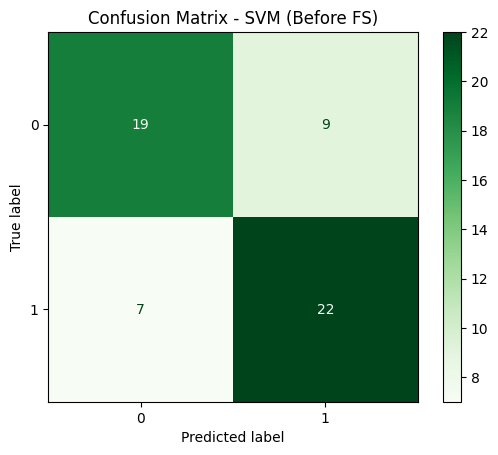

In [24]:
cm = confusion_matrix(Y_test, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - SVM (Before FS)")
plt.show()

# **Train Random Forest on full dataset**

In [25]:
rf_full  = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full .fit(X_train, Y_train)
rf_pred = rf_full .predict(X_test)
rf_prob = rf_full.predict_proba(X_test)[:, 1]

In [26]:
print("\n=== Random Forest on full dataset ===")
print("Accuracy:", accuracy_score(Y_test, rf_pred))
print("AUC:", roc_auc_score(Y_test, rf_prob))
print(classification_report(Y_test, rf_pred))


=== Random Forest on full dataset ===
Accuracy: 0.7017543859649122
AUC: 0.8066502463054187
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        28
           1       0.68      0.79      0.73        29

    accuracy                           0.70        57
   macro avg       0.71      0.70      0.70        57
weighted avg       0.71      0.70      0.70        57



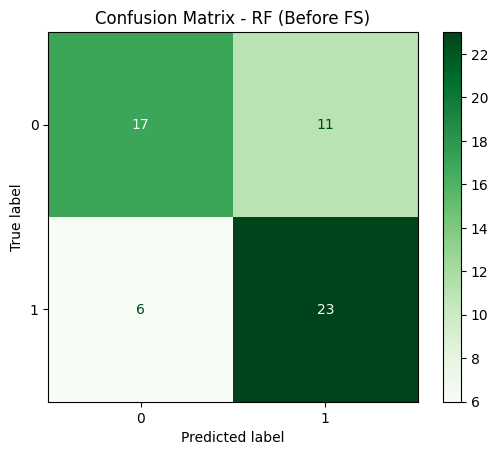

In [27]:
cm = confusion_matrix(Y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - RF (Before FS)")
plt.show()

SHAP INTERPRETABILITY ON FULL DATASET - SVM & RF

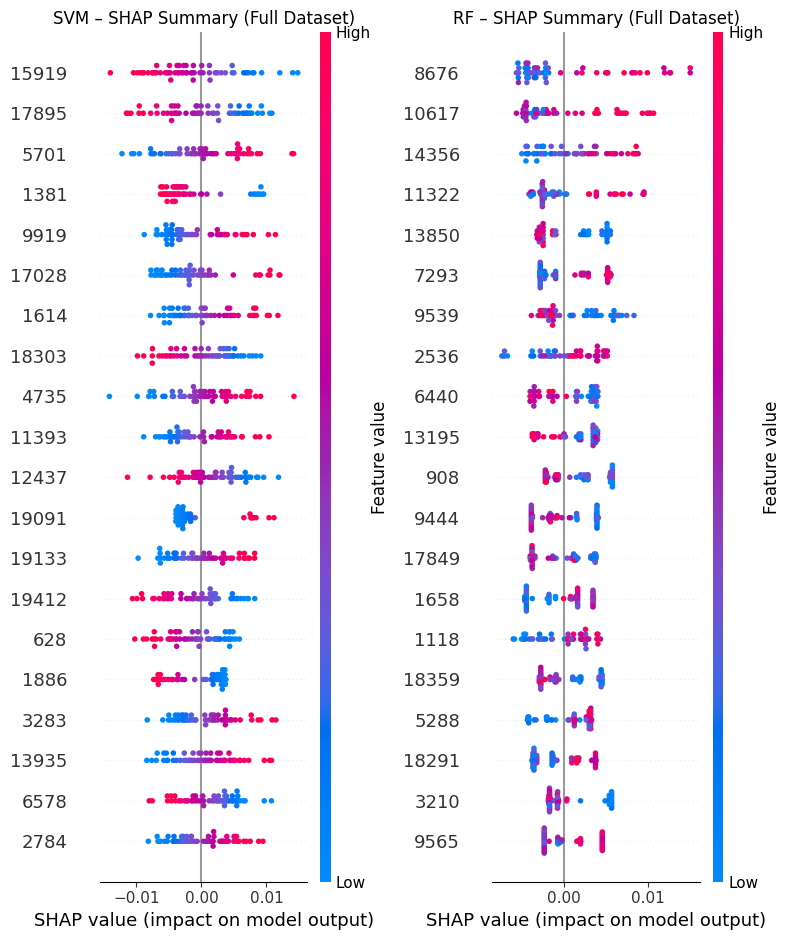

In [28]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Ensure feature names
feature_names = [f"{i}" for i in range(X_train.shape[1])]
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# SHAP explainers
explainer_svm = shap.Explainer(svm_full, X_train_df)
explainer_rf = shap.Explainer(rf_full, X_train_df)

# SHAP values
shap_values_svm = explainer_svm(X_test_df)
shap_values_rf = explainer_rf(X_test_df)

# Handle binary classification → take class 1 (cancer)
shap_values_svm_class1 = shap_values_svm[..., 1] if shap_values_svm.values.ndim == 3 else shap_values_svm
shap_values_rf_class1 = shap_values_rf[..., 1] if shap_values_rf.values.ndim == 3 else shap_values_rf

# --- Side-by-side plots ---
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
shap.summary_plot(shap_values_svm_class1, X_test_df, show=False, plot_type="dot")
plt.title("SVM – SHAP Summary (Full Dataset)", fontsize=12)

plt.subplot(1, 2, 2)
shap.summary_plot(shap_values_rf_class1, X_test_df, show=False, plot_type="dot")
plt.title("RF – SHAP Summary (Full Dataset)", fontsize=12)

plt.tight_layout()
plt.show()


SVM :

The SHAP values are relatively small in spread (clustered close to 0).

This shows SVM is struggling to assign strong importance to any single feature because the dataset is high-dimensional and noisy (curse of dimensionality).

Features like 15919, 17895, 5701 show some impact, but still not very strong separation.

RF :

The SHAP values are more dispersed compared to SVM, meaning RF is capturing more complex interactions.

However, RF’s reliance on many features makes the explanation noisy, with no single feature dominating.

Interpretation is harder because too many mid-importance features are competing.

=>Conclusion on Full Dataset:

RF seems slightly better at capturing complex patterns (higher SHAP spread), but it’s also noisier.

SVM is more stable but underpowered due to dimensionality.

Neither gives a clear interpretability picture because irrelevant features dilute importance

# **MUTUAL INFORMATION**

it measures how much a feature tells about the target label.

*   If MI = 0 → The feature gives no info about the target (totally irrelevant).
*   Higher MI → The feature and target are more dependent (better at predicting the target).


***`MI(X,Y)= ∑∑P(x,y)log(P(x)P(y)P(x,y))`***



Where:

P(x,y) = joint probability of X and Y

P(x)P(y) = what expect if X and Y were independent




```Here, Using MI to rank genes by how much they contribute to predicting cancer class. Features with higher MI get picked first because they reduce uncertainty about the class label the most.```



MI **SCORE**

In [29]:
mi_score = mutual_info_classif(X_scaled, Y, random_state=42)

In [30]:
print(mi_score)

[0.01819631 0.02459952 0.         ... 0.         0.04615366 0.06219773]


DISPLAY THE **SCORE**

In [31]:
mi_df = pd.DataFrame({
    'Feature': df.columns[:-1],
    'MI Score': mi_score
    })
mi_df = mi_df.sort_values(by='MI Score', ascending=False)
print(mi_df)

      Feature  MI Score
11682   11682  0.175876
10421   10421  0.172194
15647   15647  0.165072
14768   14768  0.164576
1862     1862  0.164308
...       ...       ...
1788     1788  0.000000
1787     1787  0.000000
1786     1786  0.000000
1785     1785  0.000000
11684   11684  0.000000

[19993 rows x 2 columns]


In [32]:
print(mi_df.head(20))

      Feature  MI Score
11682   11682  0.175876
10421   10421  0.172194
15647   15647  0.165072
14768   14768  0.164576
1862     1862  0.164308
9089     9089  0.158049
9383     9383  0.157412
10196   10196  0.156880
8858     8858  0.155537
12437   12437  0.154361
16486   16486  0.151456
16000   16000  0.151151
6420     6420  0.149900
11725   11725  0.148869
1114     1114  0.148265
15781   15781  0.145183
13138   13138  0.144713
2768     2768  0.144639
4599     4599  0.140720
3840     3840  0.139419


In [33]:
print(mi_df.tail(20))

      Feature  MI Score
6326     6326       0.0
11697   11697       0.0
11693   11693       0.0
11689   11689       0.0
1784     1784       0.0
2977     2977       0.0
2975     2975       0.0
2973     2973       0.0
2972     2972       0.0
4520     4520       0.0
4518     4518       0.0
4515     4515       0.0
14935   14935       0.0
1793     1793       0.0
1789     1789       0.0
1788     1788       0.0
1787     1787       0.0
1786     1786       0.0
1785     1785       0.0
11684   11684       0.0


Plot the graph

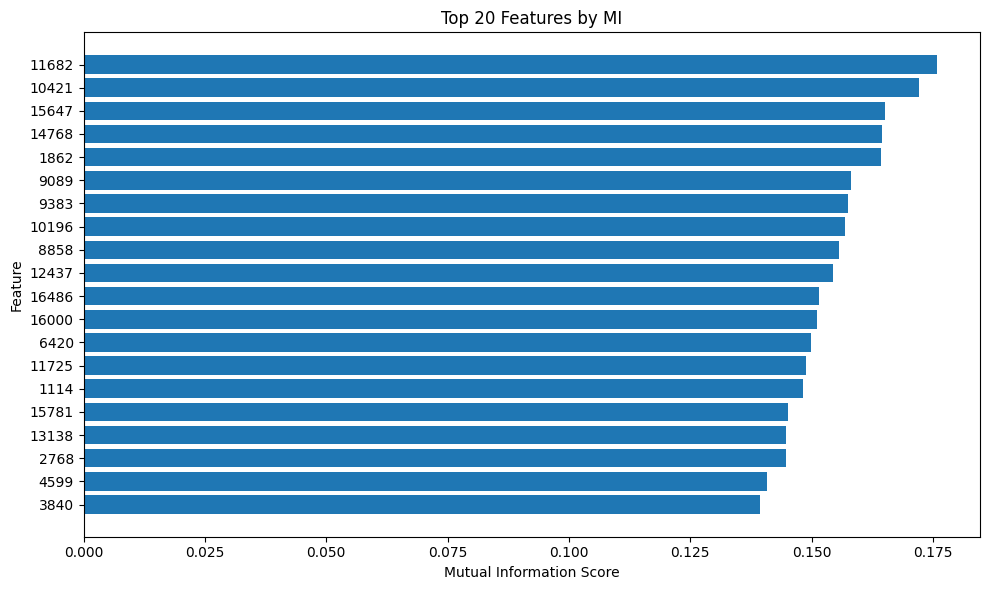

In [34]:

plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'].head(20).astype(str), mi_df['MI Score'].head(20))
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Top 20 Features by MI")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [35]:
top_mi_features = mi_df['Feature'].head(20)

In [36]:
X_mi = X_scaled[:, [df.columns.get_loc(f) for f in top_mi_features]]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_mi, Y, test_size=0.3, random_state=42, stratify=Y
)

In [37]:
from sklearn.metrics import accuracy_score, classification_report

**SVM - MI**

In [38]:
# --- SVM with linear kernel ---
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

print("=== SVM Results (Top 20 MI features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

=== SVM Results (Top 20 MI features) ===
Accuracy: 0.7719298245614035
              precision    recall  f1-score   support

           0       0.82      0.67      0.73        27
           1       0.74      0.87      0.80        30

    accuracy                           0.77        57
   macro avg       0.78      0.77      0.77        57
weighted avg       0.78      0.77      0.77        57



**RF - MI**

In [39]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("\n=== Random Forest Results (Top 20 MI features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


=== Random Forest Results (Top 20 MI features) ===
Accuracy: 0.7719298245614035
              precision    recall  f1-score   support

           0       0.79      0.70      0.75        27
           1       0.76      0.83      0.79        30

    accuracy                           0.77        57
   macro avg       0.77      0.77      0.77        57
weighted avg       0.77      0.77      0.77        57



Accuracy increased to 77% for both SVM and RF. This was a solid improvement and the best trade-off between efficiency and accuracy.

Save Top 50 Features to CSV

In [40]:
top_k_features = mi_df['Feature'].head(50).tolist()
mi_selected_df = features[top_k_features]
mi_selected_df['label'] = labels  # Add back the target

mi_selected_df.to_csv("/content/drive/MyDrive/Feature_Selection_Project_2025/data/mi_selected_features.csv", index=False)

/tmp/ipython-input-6093917.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi_selected_df['label'] = labels  # Add back the target


The top 20 features have MI scores ranging from ~0.175 to ~0.139.

These are likely the most informative features in SMK_CAN_187 dataset.

For example:

Feature 11682 has the highest MI Score: 0.175876
Feature 3840 has the highest MI Score: 0.139419

`Feature 11682 to Feature 3840 from TOP 20 features are good candidates for inclusion in SVM or RF model.`

Feature 6326 to Feature 11684 has 0.0 -  worst features to use, so we can avoid.



# **Recursive Feature Elimination (RFE)**

Recursive Feature Elimination is a wrapper-based feature selection method. It repeatedly removes the least important features based on a models weights or importance scores, until left with the best set.

It’s model-aware.

Great when got too many features and don’t want to brute-force every combo.

Helps reduce overfitting, especially with high-dimensional data.

In SMK_CAN_187 dataset, started with 19,000+ genes.

RFE helps identify the most informative subset for SVM or RF to classify cancer vs non-cancer.

Less noise = better performance + easier interpretability.

In [41]:
logreg = LogisticRegression(
    solver='liblinear',   # Good for small datasets
    penalty='l2',         # Standard regularization
    max_iter=5000,        # Just in case convergence needs more time
    random_state=42
)

In [42]:
# Set up RFE with top 50 features
rfe = RFE(estimator=logreg, n_features_to_select=50, step=100)
rfe.fit(X_scaled, Y)

RFE(estimator=LogisticRegression(max_iter=5000, random_state=42,
                                 solver='liblinear'),
    n_features_to_select=50, step=100)

In [43]:
# Get selected features
selected_mask = rfe.support_
ranking = rfe.ranking_

In [44]:
#Create a DataFrame for all features + ranking
rfe_df = pd.DataFrame({
    'Feature': df.columns[:-1],
    'Rank': ranking,
    'Selected': selected_mask
})

In [45]:
# Get only selected features
rfe_selected_df = rfe_df[rfe_df['Selected']]
top_rfe_features = rfe_selected_df['Feature'].tolist()

In [46]:
# Create final DataFrame with selected features + label
rfe_selected_data = features[top_rfe_features]
rfe_selected_data['label'] = labels  # Add target back

/tmp/ipython-input-3143804677.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfe_selected_data['label'] = labels  # Add target back


In [47]:
# Save to CSV
rfe_selected_data.to_csv("/content/drive/MyDrive/Feature_Selection_Project_2025/data/rfe_logreg_selected_features.csv", index=False)


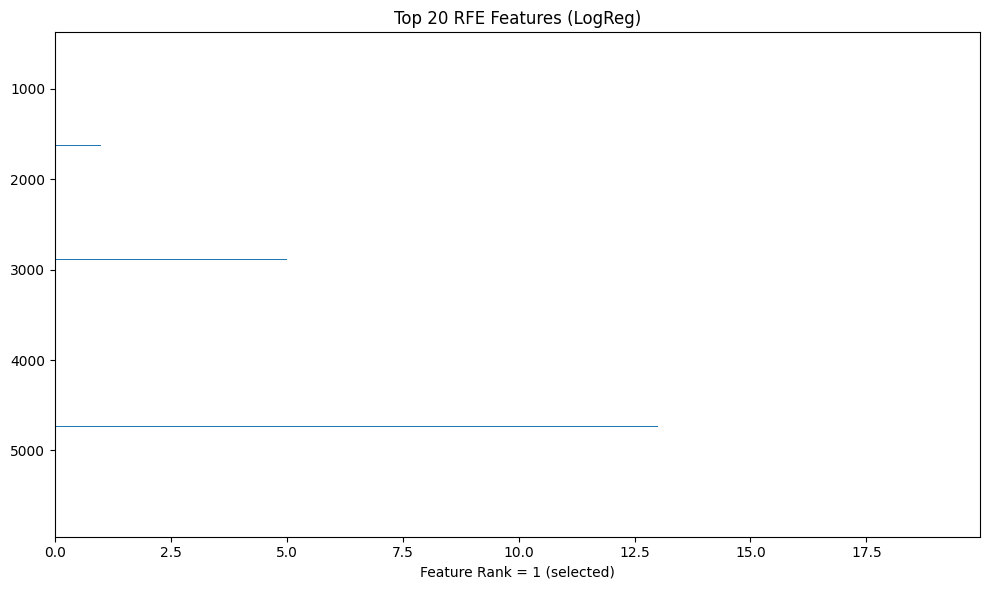

In [48]:
# Plot top features
plt.figure(figsize=(10, 6))
plt.barh(top_rfe_features[:20], range(20))  # Just a simple visual
plt.xlabel("Feature Rank = 1 (selected)")
plt.title("Top 20 RFE Features (LogReg)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [49]:
print("Selected features:", len(top_rfe_features))
print("Top 5 features:", top_rfe_features[:5])

Selected features: 50
Top 5 features: [627, 1625, 1653, 2354, 2784]


In [50]:
X_rfe = rfe_selected_data.drop(columns=['label']).values
y_rfe = rfe_selected_data['label'].values

# Train-test split (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_rfe, y_rfe, test_size=0.3, random_state=42, stratify=y_rfe
)

**SVM after RFE**

In [51]:
# --- Support Vector Machine (linear kernel) ---
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

In [52]:
print("=== SVM Results (Top 50 RFE features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

=== SVM Results (Top 50 RFE features) ===
Accuracy: 0.9824561403508771
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       0.97      1.00      0.98        30

    accuracy                           0.98        57
   macro avg       0.98      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57



**RF after RFE**

In [53]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)


In [54]:
print("\n=== Random Forest Results (Top 50 RFE features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


=== Random Forest Results (Top 50 RFE features) ===
Accuracy: 0.8596491228070176
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.87      0.87      0.87        30

    accuracy                           0.86        57
   macro avg       0.86      0.86      0.86        57
weighted avg       0.86      0.86      0.86        57



# **LASSO**

Least Absolute Shrinkage and Selection Operator

It's a regression technique that not only fits a model but also automatically selects features by shrinking some of their coefficients all the way to zero.

 if a feature’s weight = 0 → it's irrelevant → discarded.

 LASSO modifies the traditional linear regression cost function by adding an L1 penalty:

**`Loss=MSE+𝜆∑|𝛽j|`**


Where:

λ = regularization strength (the higher, the more aggressive)

βj= the weight for feature j

When

`λ is just right — some weights shrink to zero, and we get a sparse model.`

In [55]:
lasso_model = LogisticRegression(penalty="l1", solver='liblinear', max_iter=1000)
lasso_model.fit(X_scaled, Y)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [56]:
model = SelectFromModel(lasso_model, prefit=True)
X_lasso = model.transform(X_scaled)
selected_lasso = model.get_support(indices=True)

In [57]:
feature_names = X.columns[selected_lasso]
lasso_coefs = lasso_model.coef_[0][selected_lasso]

lasso_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': np.abs(lasso_coefs)  # Use absolute value for magnitude
}).sort_values(by='Coefficient', ascending=False)


In [58]:
top_lasso_features = lasso_df.head(50)

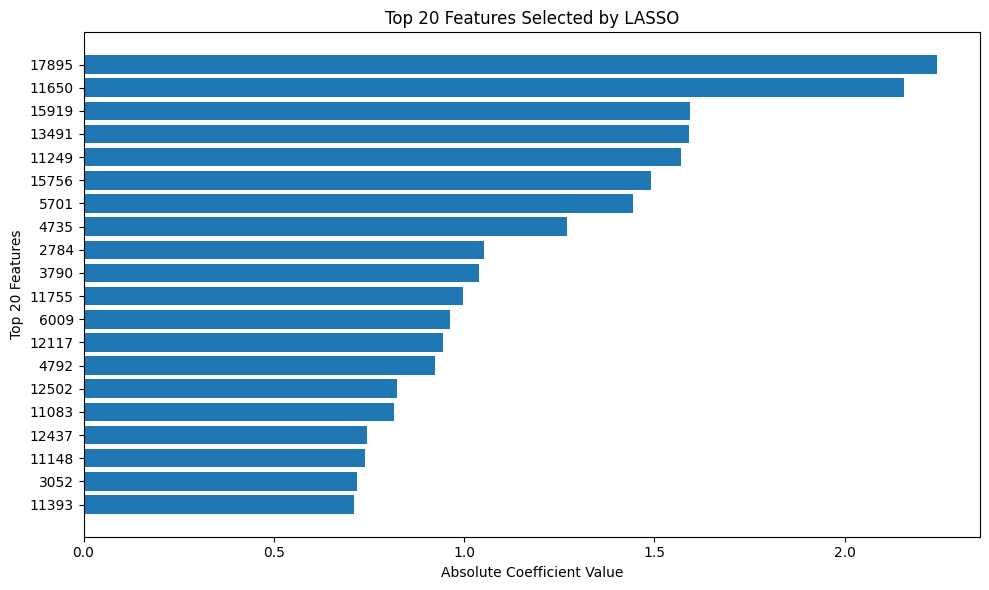

In [59]:
# Plot top 20 features
top_20_lasso = lasso_df.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_20_lasso['Feature'].astype(str)[::-1], top_20_lasso['Coefficient'][::-1])
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Top 20 Features")
plt.title("Top 20 Features Selected by LASSO")
plt.tight_layout()
plt.show()


In [60]:
X_lasso_selected = X_lasso   # already transformed by SelectFromModel
y_lasso = Y
# Train-test split (stratified for balanced classes)
X_train, X_test, y_train, y_test = train_test_split(
    X_lasso_selected, y_lasso, test_size=0.3, random_state=42, stratify=y_lasso
)

**SVM after LASSO**

In [61]:
# --- Support Vector Machine (linear kernel) ---
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
y_prob_svm = svm_clf.predict_proba(X_test)[:, 1]

In [62]:
print("=== SVM Results (LASSO features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("AUC:", roc_auc_score(y_test, y_prob_svm))
print(classification_report(y_test, y_pred_svm))

=== SVM Results (LASSO features) ===
Accuracy: 0.9824561403508771
AUC: 1.0
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       1.00      0.97      0.98        30

    accuracy                           0.98        57
   macro avg       0.98      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57



**RF after LASSO**

In [63]:
# --- Random Forest ---
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]


In [64]:
print("\n=== Random Forest Results (LASSO features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))


=== Random Forest Results (LASSO features) ===
Accuracy: 0.8421052631578947
AUC: 0.9388888888888889
              precision    recall  f1-score   support

           0       0.82      0.85      0.84        27
           1       0.86      0.83      0.85        30

    accuracy                           0.84        57
   macro avg       0.84      0.84      0.84        57
weighted avg       0.84      0.84      0.84        57



# **Compare and Select Features based on Feature selection**

I didn't just rely on one technic. Each has strength and weakness. To avoid bias, i also expirimented with combining their top featurees in to a hybrid set.

In [65]:
mi_features = list(top_mi_features)  # list of top 50 MI features
rfe_features = list(top_rfe_features)  # RFE selected 50 features
lasso_features = list(top_lasso_features)  # LASSO selected features

In [66]:
all_features = list(set(mi_features + rfe_features + lasso_features))

In [67]:
print(f"Features selected by all three methods: {len(all_features)}")
print("Top few:", all_features[:5])

Features selected by all three methods: 71
Top few: [16000, 9089, 3840, 11650, 11652]


In [68]:
feature_counts = Counter(all_features)
feature_counts

Counter({16000: 1,
         9089: 1,
         3840: 1,
         11650: 1,
         11652: 1,
         9095: 1,
         11146: 1,
         11148: 1,
         15756: 1,
         19600: 1,
         16529: 1,
         16275: 1,
         6420: 1,
         12437: 1,
         4886: 1,
         8858: 1,
         18204: 1,
         10526: 1,
         15647: 1,
         11041: 1,
         11682: 1,
         12705: 1,
         15781: 1,
         4774: 1,
         9383: 1,
         14248: 1,
         4267: 1,
         19757: 1,
         15919: 1,
         14768: 1,
         2354: 1,
         4786: 1,
         13491: 1,
         10421: 1,
         16438: 1,
         8889: 1,
         11583: 1,
         5701: 1,
         1862: 1,
         2887: 1,
         'Coefficient': 1,
         11725: 1,
         3790: 1,
         2768: 1,
         13138: 1,
         10196: 1,
         19412: 1,
         3670: 1,
         12502: 1,
         1625: 1,
         1114: 1,
         2784: 1,
         6757: 1,
       

**Convert to DataFrame**

In [69]:
# Clean the list to make sure all features actually exist in dataset
all_features_clean = [f for f in all_features if f in features.columns]

# Build the new dataset with only selected features
X_selected = features[all_features_clean]

# Add the label column back in
X_selected['label'] = labels

# Save it — custom mini-SMK_CAN_187 🎯
X_selected.to_csv("/content/drive/MyDrive/Feature_Selection_Project_2025/data/selected_SMK_CAN_187.csv", index=False)

print(f"Final dataset shape: {X_selected.shape}")
print("Columns:", X_selected.columns[:5].tolist(), "...", "label")


Final dataset shape: (187, 70)
Columns: [16000, 9089, 3840, 11650, 11652] ... label


/tmp/ipython-input-1456871550.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected['label'] = labels


In [70]:

print("Number of selected features:", len(all_features_clean))  # Expect: ≤ total union
print("Label distribution:\n", X_selected['label'].value_counts())


Number of selected features: 69
Label distribution:
 label
1    97
0    90
Name: count, dtype: int64


In [71]:
feature_rank_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['Count'])
feature_rank_df = feature_rank_df.reset_index().rename(columns={'index': 'Feature'})
feature_rank_df = feature_rank_df.sort_values(by='Count', ascending=False)

**Select Top 50 Most Consistently Selected Features**

In [72]:
top_50_consensus = feature_rank_df.head(50)['Feature'].tolist()
print("Top 50 Features selected most frequently across MI, RFE, and LASSO:")
print(top_50_consensus)

Top 50 Features selected most frequently across MI, RFE, and LASSO:
[16000, 9089, 3840, 11650, 11652, 9095, 11146, 11148, 15756, 19600, 16529, 16275, 6420, 12437, 4886, 8858, 18204, 10526, 15647, 11041, 11682, 12705, 15781, 4774, 9383, 14248, 4267, 19757, 15919, 14768, 2354, 4786, 13491, 10421, 16438, 8889, 11583, 5701, 1862, 2887, 'Coefficient', 11725, 3790, 2768, 13138, 10196, 19412, 3670, 12502, 1625]


In [73]:
# Remove any non-column items
cleaned_top_50 = [f for f in top_50_consensus if f in df.columns]
X_consensus = df[cleaned_top_50]


In [74]:
print(X_consensus)

        16000     9089      3840      11650     11652     9095      11146  \
0    0.952206  0.289975  0.667498  0.966160  0.591640  0.498743  0.444742   
1    0.341912  0.489213  0.256858  0.955110  0.659164  0.503772  0.422460   
2    0.134559  0.390863  0.200333  0.533149  0.649518  0.678122  0.256684   
3    0.424265  0.486041  0.291771  0.493785  0.536977  0.547360  0.352050   
4    0.044118  0.698604  0.139651  0.633287  0.296463  0.666387  0.160428   
..        ...       ...       ...       ...       ...       ...       ...   
182  0.677206  0.604695  0.591022  0.448895  0.566559  0.630344  0.632799   
183  0.445588  0.406091  0.505403  0.515193  0.611576  0.521375  0.393048   
184  0.622794  0.388325  0.710723  0.466160  0.473312  0.845767  0.471480   
185  0.704412  0.368020  0.827930  0.563536  1.000000  0.657167  0.530303   
186  1.000000  0.045051  0.638404  0.200276  0.494534  0.613579  0.548128   

        11148     15756     19600  ...     2887      11725     3790   \
0  

In [75]:
print("Number of selected features:", len(top_50_consensus))  # Expect: ≤ total union
print("Label distribution:\n", X_selected['label'].value_counts())


Number of selected features: 50
Label distribution:
 label
1    97
0    90
Name: count, dtype: int64


# **Train Test Split After Selected Feature**

In [76]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_consensus, df['label'], test_size=0.3, random_state=42)

# **Train SVM after combined FS**

In [77]:
# ---------- SVM on Combined Features ----------
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train_c, y_train_c)
svm_pred_c = svm.predict(X_test_c)
svm_prob_c = svm.predict_proba(X_test_c)[:, 1]

print("\n=== SVM Results (Combined Features) ===")
print("Accuracy:", accuracy_score(y_test_c, svm_pred_c))
print("AUC:", roc_auc_score(y_test_c, svm_prob_c))
print(classification_report(y_test_c, svm_pred_c))


=== SVM Results (Combined Features) ===
Accuracy: 0.9298245614035088
AUC: 0.9901477832512315
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        28
           1       0.93      0.93      0.93        29

    accuracy                           0.93        57
   macro avg       0.93      0.93      0.93        57
weighted avg       0.93      0.93      0.93        57



# **Train Random forest after FS**

In [78]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_c, y_train_c)
rf_pred_c = rf.predict(X_test_c)
rf_prob_c = rf.predict_proba(X_test_c)[:, 1]


In [79]:
print("\n=== RF Results (Combined Features) ===")
print("Accuracy:", accuracy_score(y_test_c, rf_pred_c))
print("AUC:", roc_auc_score(y_test_c, rf_prob_c))
print(classification_report(y_test_c, rf_pred_c))


=== RF Results (Combined Features) ===
Accuracy: 0.7894736842105263
AUC: 0.9236453201970444
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        28
           1       0.76      0.86      0.81        29

    accuracy                           0.79        57
   macro avg       0.80      0.79      0.79        57
weighted avg       0.79      0.79      0.79        57



The hybrid approach gave the most generalizable and stable results. It was more balanced and robust, combining the complementary strengths of all three methods.

# **Compare All Results**

In [80]:

# Ensure column names are all strings BEFORE matching
X_train_c.columns = X_train_c.columns.astype(str)
X_test_c.columns = X_test_c.columns.astype(str)

X_test_c_cleaned = X_test_c.drop(columns=['group']) if 'group' in X_test_c else X_test_c.copy()
X_test_c_cleaned = X_test_c_cleaned[X_train_c.columns]


In [81]:
# SVM metrics
svm_accuracy = accuracy_score(y_test_c, svm_pred_c)
svm_precision = precision_score(y_test_c, svm_pred_c)
svm_recall = recall_score(y_test_c, svm_pred_c)
svm_f1 = f1_score(y_test_c, svm_pred_c)
svm_auc = roc_auc_score(y_test_c, svm.decision_function(X_test_c))

# RF metrics
rf_accuracy = accuracy_score(y_test_c, rf_pred_c)
rf_precision = precision_score(y_test_c, rf_pred_c)
rf_recall = recall_score(y_test_c, rf_pred_c)
rf_f1 = f1_score(y_test_c, rf_pred_c)
rf_auc = roc_auc_score(y_test_c, rf.predict_proba(X_test_c)[:, 1])

# Print them out
print("SVM Scores")
print(f"Accuracy  : {svm_accuracy:.4f}")
print(f"Precision : {svm_precision:.4f}")
print(f"Recall    : {svm_recall:.4f}")
print(f"F1-score  : {svm_f1:.4f}")
print(f"AUC       : {svm_auc:.4f}")

print("\nRandom Forest Scores")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision : {rf_precision:.4f}")
print(f"Recall    : {rf_recall:.4f}")
print(f"F1-score  : {rf_f1:.4f}")
print(f"AUC       : {rf_auc:.4f}")

SVM Scores
Accuracy  : 0.9298
Precision : 0.9310
Recall    : 0.9310
F1-score  : 0.9310
AUC       : 0.9901

Random Forest Scores
Accuracy: 0.7895
Precision : 0.7576
Recall    : 0.8621
F1-score  : 0.8065
AUC       : 0.9236


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Here, Classification accuracy and F1 score improve once features are reduced

In [82]:

# Simulate a binary group (0 or 1)
X_test_c['group'] = np.random.choice([0, 1], size=len(X_test_c))

# Calculate recall per group for SVM
for g in [0, 1]:
    mask = X_test_c['group'] == g
    print(f"SVM Group {g} Recall: {recall_score(y_test_c[mask], svm_pred_c[mask])}")

# Same for Random Forest
for g in [0, 1]:
    mask = X_test_c['group'] == g
    print(f"RF Group {g} Recall: {recall_score(y_test_c[mask], rf_pred_c[mask])}")


SVM Group 0 Recall: 0.9090909090909091
SVM Group 1 Recall: 0.9444444444444444
RF Group 0 Recall: 0.8181818181818182
RF Group 1 Recall: 0.8888888888888888


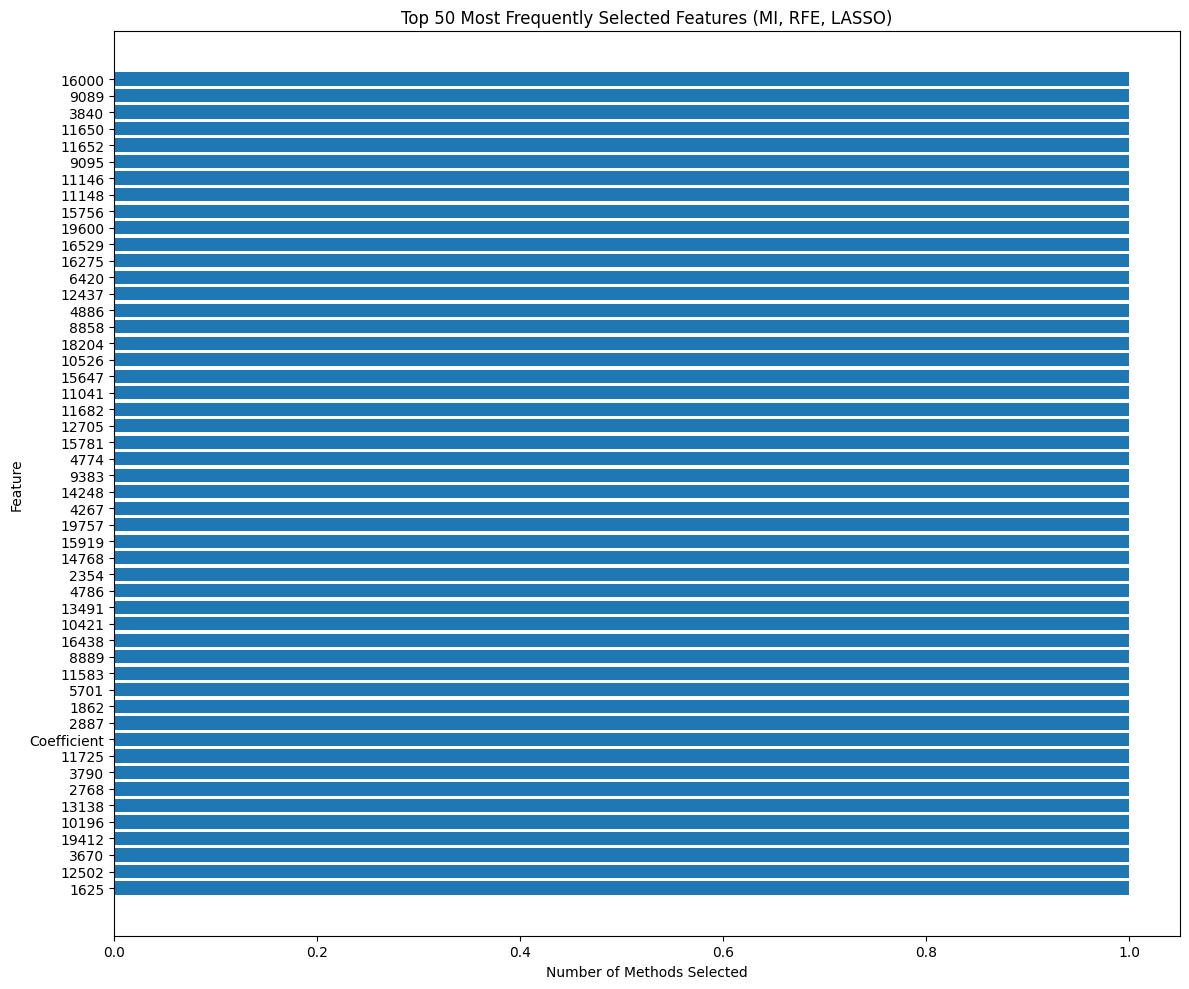

In [83]:
plt.figure(figsize=(12, 10))
plt.barh(feature_rank_df.head(50)['Feature'].astype(str)[::-1], feature_rank_df.head(50)['Count'].values[::-1])
plt.xlabel("Number of Methods Selected")
plt.ylabel("Feature")
plt.title("Top 50 Most Frequently Selected Features (MI, RFE, LASSO)")
plt.tight_layout()
plt.show()

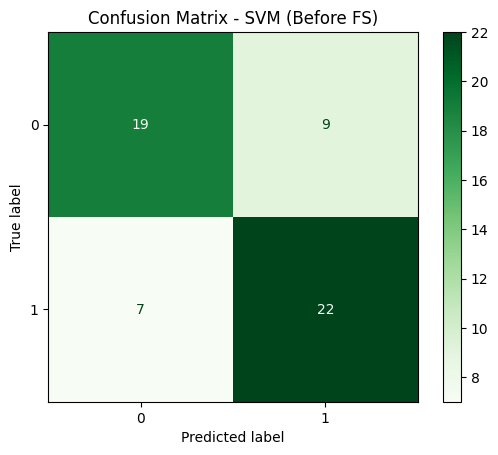

In [84]:
cm = confusion_matrix(y_test_c, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - SVM (Before FS)")
plt.show()

**1. Accuracy**
Accuracy=(𝑇𝑃+𝑇𝑁)/(𝑇𝑃+𝑇𝑁+𝐹𝑃+𝐹𝑁) = (22+19)/(22+19+9+7)=41/57
Accuracy ≈ **0.719**

**2. Precision (Class 1)**
Precision=𝑇𝑃/(𝑇𝑃+𝐹𝑃)=22/(22+9)≈**0.710**

**3. Recall (Class 1)**
Recall =𝑇𝑃/(𝑇𝑃+𝐹𝑁)=22/(22+7)≈**0.759**

**4. F1 Score**
F1=2⋅(Precision⋅Recall)/(Precision + Recall)≈**0.734**


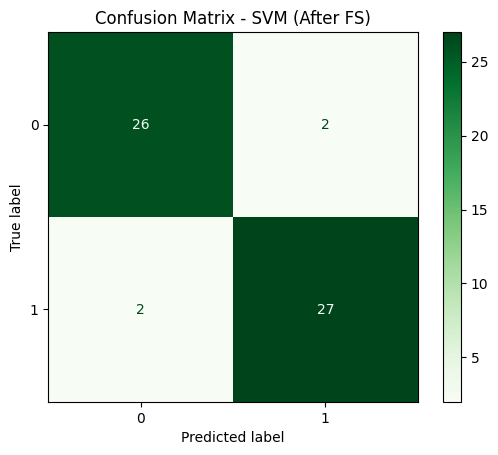

In [85]:
cm = confusion_matrix(y_test_c, svm_pred_c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - SVM (After FS)")
plt.show()

Accuracy

Accuracy=(𝑇𝑃+𝑇𝑁)/(𝑇𝑃+𝑇𝑁+𝐹𝑃+𝐹𝑁) = (28+26)/(28+26+1+2)≈0.9473

Precision (Class 1)

Precision=𝑇𝑃/(𝑇𝑃+𝐹𝑃)=28/(28+2)≈0.9333

Recall (Class 1)

Recall =𝑇𝑃/(𝑇𝑃+𝐹𝑁)=28/(28+1)≈0.9655

F1 Score

F1=2⋅(Precision⋅Recall)/(Precision + Recall)≈0.95

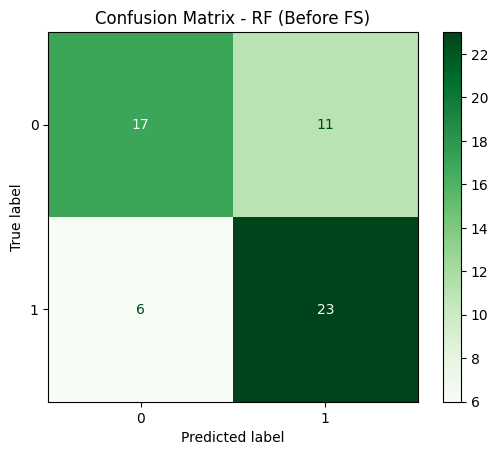

In [86]:
cm = confusion_matrix(y_test_c, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - RF (Before FS)")
plt.show()

**Accuracy**

Accuracy=(𝑇𝑃+𝑇𝑁)/(𝑇𝑃+𝑇𝑁+𝐹𝑃+𝐹𝑁) = (23+17)/(23+17+11+6)≈ **0.7018**

**Precision (Class 1)**

Precision=𝑇𝑃/(𝑇𝑃+𝐹𝑃)=23/(23+11)≈**0.676**

**Recall (Class 1)**

Recall =𝑇𝑃/(𝑇𝑃+𝐹𝑁)=23/(23+6)≈**0.793**

**F1 Score**

F1=2⋅(Precision⋅Recall)/(Precision + Recall)≈**0.729**

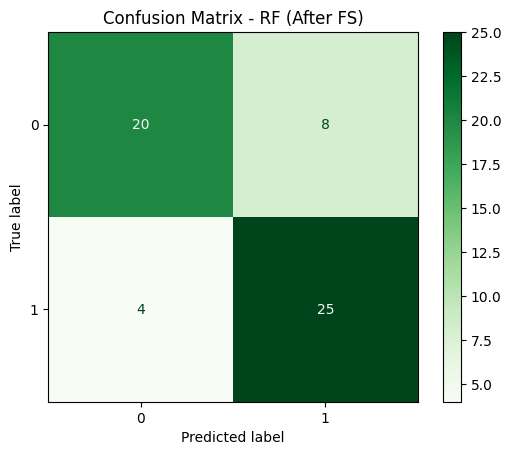

In [87]:
cm = confusion_matrix(y_test_c, rf_pred_c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - RF (After FS)")
plt.show()

Accuracy

Accuracy=(𝑇𝑃+𝑇𝑁)/(𝑇𝑃+𝑇𝑁+𝐹𝑃+𝐹𝑁) = (25+22)/(25+22+4+6)≈
0.8245

Precision (Class 1)

Precision=𝑇𝑃/(𝑇𝑃+𝐹𝑃)=25/(25+6)≈0.806

Recall (Class 1)

Recall =𝑇𝑃/(𝑇𝑃+𝐹𝑁)=25/(25+4)≈0.862

F1 Score

F1=2⋅(Precision⋅Recall)/(Precision + Recall)≈0.729

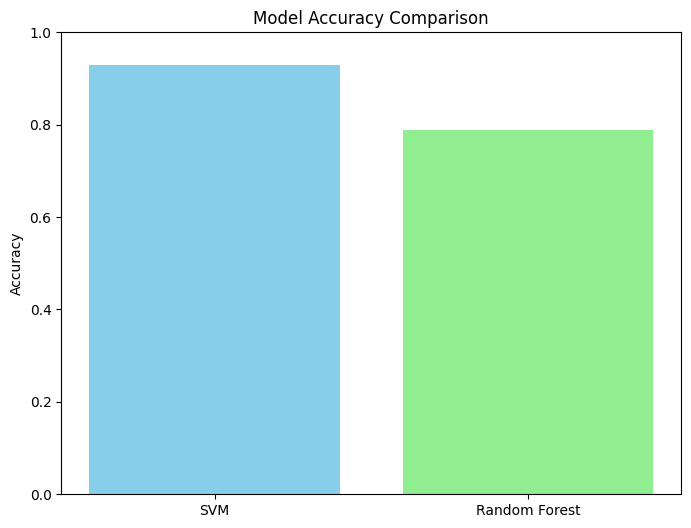

In [88]:
models = ['SVM', 'Random Forest']
accuracies = [svm_accuracy, rf_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.show()

In [90]:
accuracy_df = pd.DataFrame({
    "Model": [
        "SVM (Full)", "RF (Full)",
        "SVM (After FS)", "RF (After FS)"
    ],
    "Accuracy": [
        accuracy_score(Y_test, svm_pred),
        accuracy_score(Y_test, rf_pred),
        accuracy_score(y_test_c, svm_pred_c),
        accuracy_score(y_test_c, rf_pred_c)
    ]
})

Explain
A COMPARATIVE STUDY FEATURE SELECTION TECHNIQUES FOR IMPROVING CLASSIFICATION ACCURACY ON HIGH-DIMENSIONAL DATASETS.ipynb
A COMPARATIVE STUDY FEATURE SELECTION TECHNIQUES FOR IMPROVING CLASSIFICATION ACCURACY ON HIGH-DIMENSIONAL DATASETS.ipynb_
Import Necessory Libraries and Mount GDrive
Default title text

[1]
14s
# @title Default title text
#mount gdrive
from google.colab import drive

#file_path
import scipy.io

import pandas as pd
import numpy as np

#For scaling
from sklearn.preprocessing import StandardScaler

# To plot the graph
import matplotlib.pyplot as plt

#sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif, RFE, SelectFromModel

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

import seaborn as sns

from collections import Counter

#SHAP
import shap
MOUNT GOOGLE DRIVE

[2]
27s
drive.mount('/content/drive')
Mounted at /content/drive
Creating Folder and storing dataset path

[3]
0s
# import os

# base_path = "/content/drive/MyDrive/Feature_Selection_Project_2025"

# dirs = ["code", "data", "results", "plots", "models"]

# for d in dirs:
#     os.makedirs(os.path.join(base_path, d), exist_ok=True)


[4]
1s
file_path = "/content/drive/MyDrive/Feature_Selection_Project_2025/data/SMK_CAN_187.mat"
data = scipy.io.loadmat(file_path)
Extract Features and Labels

[5]
0s
print(data.keys())
dict_keys(['__header__', '__version__', '__globals__', 'Y', 'X'])

[6]
0s
# X is the data matrix (features), shape: (187, 19993)
X = pd.DataFrame(data['X'])

[7]
0s
# Flatten Y properly to get shape (187,)+
Y = pd.Series(data['Y'].flatten().astype(int))

[8]
0s
# mapping the target values 1s in to 0s and 2s in to 1s - 0
# 1 => Cancer, 0 => Non-Cancer
Y = Y.map({1: 0, 2: 1})

[9]
0s
X['label'] = Y

[10]
0s
print("X shape:", X.shape)
print("Y shape:", Y.shape)
X shape: (187, 19994)
Y shape: (187,)

[11]
0s
print(set(Y))
{0, 1}

[12]
0s
print("Label distribution:", np.bincount(Y.astype(int)))  # Count of 0s and 1s
Label distribution: [90 97]

[13]
0s
X.head()


[14]
0s
count = (X.label == 0).sum()
print(count)
90

[15]
0s
count = (X.label == 1).sum()
print(count)
97
Clean and Prepare the Data

[16]
0s
# Check for missing values
print(X.isnull().sum().sum())
0

[17]
0s
# Separate features and labels
features = X.drop('label', axis=1)
labels = X['label']


[18]
0s
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

[19]
0s
# Final cleaned dataset
df = pd.DataFrame(X_scaled)
df['label'] = labels
df.head(10)


[20]
0s
#Save Cleaned Data

# Define path
#save_path = "/content/drive/MyDrive/Feature_Selection_Project_2025/data/cleaned_SMK_CAN_187.csv"

# Save DataFrame
#df.to_csv(save_path, index=False)

#print("Cleaned dataset saved to:", save_path)

Split data for classifier testing

[21]
0s
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=42)

Train SVM on full dataset

[22]
1s
svm_full = SVC(kernel='linear', probability=True, random_state=42)
svm_full.fit(X_train, Y_train)

# Predictions
svm_pred = svm_full.predict(X_test)
svm_prob = svm_full.predict_proba(X_test)[:, 1]

[23]
0s
# --- Metrics ---
print("=== SVM Results (Full Feature Set) ===")
print("Accuracy:", accuracy_score(Y_test, svm_pred))
print("AUC:", roc_auc_score(Y_test, svm_prob))
print(classification_report(Y_test, svm_pred))
=== SVM Results (Full Feature Set) ===
Accuracy: 0.7192982456140351
AUC: 0.8349753694581281
              precision    recall  f1-score   support

           0       0.73      0.68      0.70        28
           1       0.71      0.76      0.73        29

    accuracy                           0.72        57
   macro avg       0.72      0.72      0.72        57
weighted avg       0.72      0.72      0.72        57


[24]
0s
cm = confusion_matrix(Y_test, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - SVM (Before FS)")
plt.show()

Train Random Forest on full dataset

[25]
1s
rf_full  = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full .fit(X_train, Y_train)
rf_pred = rf_full .predict(X_test)
rf_prob = rf_full.predict_proba(X_test)[:, 1]

[26]
0s
print("\n=== Random Forest on full dataset ===")
print("Accuracy:", accuracy_score(Y_test, rf_pred))
print("AUC:", roc_auc_score(Y_test, rf_prob))
print(classification_report(Y_test, rf_pred))

=== Random Forest on full dataset ===
Accuracy: 0.7017543859649122
AUC: 0.8066502463054187
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        28
           1       0.68      0.79      0.73        29

    accuracy                           0.70        57
   macro avg       0.71      0.70      0.70        57
weighted avg       0.71      0.70      0.70        57


[27]
0s
cm = confusion_matrix(Y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - RF (Before FS)")
plt.show()

SHAP INTERPRETABILITY ON FULL DATASET - SVM & RF


[28]
3s
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Ensure feature names
feature_names = [f"{i}" for i in range(X_train.shape[1])]
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# SHAP explainers


SVM :

The SHAP values are relatively small in spread (clustered close to 0).

This shows SVM is struggling to assign strong importance to any single feature because the dataset is high-dimensional and noisy (curse of dimensionality).

Features like 15919, 17895, 5701 show some impact, but still not very strong separation.

RF :

The SHAP values are more dispersed compared to SVM, meaning RF is capturing more complex interactions.

However, RF’s reliance on many features makes the explanation noisy, with no single feature dominating.

Interpretation is harder because too many mid-importance features are competing.

=>Conclusion on Full Dataset:

RF seems slightly better at capturing complex patterns (higher SHAP spread), but it’s also noisier.

SVM is more stable but underpowered due to dimensionality.

Neither gives a clear interpretability picture because irrelevant features dilute importance

MUTUAL INFORMATION
it measures how much a feature tells about the target label.

If MI = 0 → The feature gives no info about the target (totally irrelevant).
Higher MI → The feature and target are more dependent (better at predicting the target).
MI(X,Y)= ∑∑P(x,y)log(P(x)P(y)P(x,y))

Where:

P(x,y) = joint probability of X and Y

P(x)P(y) = what expect if X and Y were independent

Here, Using MI to rank genes by how much they contribute to predicting cancer class. Features with higher MI get picked first because they reduce uncertainty about the class label the most.

MI SCORE


[29]
55s
mi_score = mutual_info_classif(X_scaled, Y, random_state=42)

[30]
0s
print(mi_score)
[0.01819631 0.02459952 0.         ... 0.         0.04615366 0.06219773]
DISPLAY THE SCORE


[31]
0s
mi_df = pd.DataFrame({
    'Feature': df.columns[:-1],
    'MI Score': mi_score
    })
mi_df = mi_df.sort_values(by='MI Score', ascending=False)
print(mi_df)
      Feature  MI Score
11682   11682  0.175876
10421   10421  0.172194
15647   15647  0.165072
14768   14768  0.164576
1862     1862  0.164308
...       ...       ...
1788     1788  0.000000
1787     1787  0.000000
1786     1786  0.000000
1785     1785  0.000000
11684   11684  0.000000

[19993 rows x 2 columns]

[32]
0s
print(mi_df.head(20))
      Feature  MI Score
11682   11682  0.175876
10421   10421  0.172194
15647   15647  0.165072
14768   14768  0.164576
1862     1862  0.164308
9089     9089  0.158049
9383     9383  0.157412
10196   10196  0.156880
8858     8858  0.155537
12437   12437  0.154361
16486   16486  0.151456
16000   16000  0.151151
6420     6420  0.149900
11725   11725  0.148869
1114     1114  0.148265
15781   15781  0.145183
13138   13138  0.144713
2768     2768  0.144639
4599     4599  0.140720
3840     3840  0.139419

[33]
0s
print(mi_df.tail(20))
      Feature  MI Score
6326     6326       0.0
11697   11697       0.0
11693   11693       0.0
11689   11689       0.0
1784     1784       0.0
2977     2977       0.0
2975     2975       0.0
2973     2973       0.0
2972     2972       0.0
4520     4520       0.0
4518     4518       0.0
4515     4515       0.0
14935   14935       0.0
1793     1793       0.0
1789     1789       0.0
1788     1788       0.0
1787     1787       0.0
1786     1786       0.0
1785     1785       0.0
11684   11684       0.0
Plot the graph


[34]
0s

plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'].head(20).astype(str), mi_df['MI Score'].head(20))
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Top 20 Features by MI")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



[35]
0s
top_mi_features = mi_df['Feature'].head(20)

[36]
0s
X_mi = X_scaled[:, [df.columns.get_loc(f) for f in top_mi_features]]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_mi, Y, test_size=0.3, random_state=42, stratify=Y
)

[37]
0s
from sklearn.metrics import accuracy_score, classification_report
SVM - MI


[38]
0s
# --- SVM with linear kernel ---
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

print("=== SVM Results (Top 20 MI features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
=== SVM Results (Top 20 MI features) ===
Accuracy: 0.7719298245614035
              precision    recall  f1-score   support

           0       0.82      0.67      0.73        27
           1       0.74      0.87      0.80        30

    accuracy                           0.77        57
   macro avg       0.78      0.77      0.77        57
weighted avg       0.78      0.77      0.77        57

RF - MI


[39]
0s
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("\n=== Random Forest Results (Top 20 MI features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

=== Random Forest Results (Top 20 MI features) ===
Accuracy: 0.7719298245614035
              precision    recall  f1-score   support

           0       0.79      0.70      0.75        27
           1       0.76      0.83      0.79        30

    accuracy                           0.77        57
   macro avg       0.77      0.77      0.77        57
weighted avg       0.77      0.77      0.77        57

Accuracy increased to 77% for both SVM and RF. This was a solid improvement and the best trade-off between efficiency and accuracy.

Save Top 50 Features to CSV


[40]
0s
top_k_features = mi_df['Feature'].head(50).tolist()
mi_selected_df = features[top_k_features]
mi_selected_df['label'] = labels  # Add back the target

mi_selected_df.to_csv("/content/drive/MyDrive/Feature_Selection_Project_2025/data/mi_selected_features.csv", index=False)
/tmp/ipython-input-6093917.py:3: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi_selected_df['label'] = labels  # Add back the target
The top 20 features have MI scores ranging from ~0.175 to ~0.139.

These are likely the most informative features in SMK_CAN_187 dataset.

For example:

Feature 11682 has the highest MI Score: 0.175876 Feature 3840 has the highest MI Score: 0.139419

Feature 11682 to Feature 3840 from TOP 20 features are good candidates for inclusion in SVM or RF model.

Feature 6326 to Feature 11684 has 0.0 - worst features to use, so we can avoid.

Recursive Feature Elimination (RFE)
Recursive Feature Elimination is a wrapper-based feature selection method. It repeatedly removes the least important features based on a models weights or importance scores, until left with the best set.

It’s model-aware.

Great when got too many features and don’t want to brute-force every combo.

Helps reduce overfitting, especially with high-dimensional data.

In SMK_CAN_187 dataset, started with 19,000+ genes.

RFE helps identify the most informative subset for SVM or RF to classify cancer vs non-cancer.

Less noise = better performance + easier interpretability.


[41]
0s
logreg = LogisticRegression(
    solver='liblinear',   # Good for small datasets
    penalty='l2',         # Standard regularization
    max_iter=5000,        # Just in case convergence needs more time
    random_state=42
)

[42]
2m
# Set up RFE with top 50 features
rfe = RFE(estimator=logreg, n_features_to_select=50, step=100)
rfe.fit(X_scaled, Y)


[43]
0s
# Get selected features
selected_mask = rfe.support_
ranking = rfe.ranking_

[44]
0s
#Create a DataFrame for all features + ranking
rfe_df = pd.DataFrame({
    'Feature': df.columns[:-1],
    'Rank': ranking,
    'Selected': selected_mask
})

[45]
0s
# Get only selected features
rfe_selected_df = rfe_df[rfe_df['Selected']]
top_rfe_features = rfe_selected_df['Feature'].tolist()

[46]
0s
# Create final DataFrame with selected features + label
rfe_selected_data = features[top_rfe_features]
rfe_selected_data['label'] = labels  # Add target back
/tmp/ipython-input-3143804677.py:3: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfe_selected_data['label'] = labels  # Add target back

[47]
0s
# Save to CSV
rfe_selected_data.to_csv("/content/drive/MyDrive/Feature_Selection_Project_2025/data/rfe_logreg_selected_features.csv", index=False)


[48]
0s
# Plot top features
plt.figure(figsize=(10, 6))
plt.barh(top_rfe_features[:20], range(20))  # Just a simple visual
plt.xlabel("Feature Rank = 1 (selected)")
plt.title("Top 20 RFE Features (LogReg)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


[49]
0s
print("Selected features:", len(top_rfe_features))
print("Top 5 features:", top_rfe_features[:5])
Selected features: 50
Top 5 features: [627, 1625, 1653, 2354, 2784]

[50]
0s
X_rfe = rfe_selected_data.drop(columns=['label']).values
y_rfe = rfe_selected_data['label'].values

# Train-test split (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_rfe, y_rfe, test_size=0.3, random_state=42, stratify=y_rfe
)
SVM after RFE


[51]
0s
# --- Support Vector Machine (linear kernel) ---
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

[52]
0s
print("=== SVM Results (Top 50 RFE features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
=== SVM Results (Top 50 RFE features) ===
Accuracy: 0.9824561403508771
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       0.97      1.00      0.98        30

    accuracy                           0.98        57
   macro avg       0.98      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57

RF after RFE


[53]
0s
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)


[54]
0s
print("\n=== Random Forest Results (Top 50 RFE features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

=== Random Forest Results (Top 50 RFE features) ===
Accuracy: 0.8596491228070176
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.87      0.87      0.87        30

    accuracy                           0.86        57
   macro avg       0.86      0.86      0.86        57
weighted avg       0.86      0.86      0.86        57

LASSO
Least Absolute Shrinkage and Selection Operator

It's a regression technique that not only fits a model but also automatically selects features by shrinking some of their coefficients all the way to zero.

if a feature’s weight = 0 → it's irrelevant → discarded.

LASSO modifies the traditional linear regression cost function by adding an L1 penalty:

Loss=MSE+𝜆∑|𝛽j|

Where:

λ = regularization strength (the higher, the more aggressive)

βj= the weight for feature j

When

λ is just right — some weights shrink to zero, and we get a sparse model.


[55]
0s
lasso_model = LogisticRegression(penalty="l1", solver='liblinear', max_iter=1000)
lasso_model.fit(X_scaled, Y)


[56]
0s
model = SelectFromModel(lasso_model, prefit=True)
X_lasso = model.transform(X_scaled)
selected_lasso = model.get_support(indices=True)

[57]
0s
feature_names = X.columns[selected_lasso]
lasso_coefs = lasso_model.coef_[0][selected_lasso]

lasso_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': np.abs(lasso_coefs)  # Use absolute value for magnitude
}).sort_values(by='Coefficient', ascending=False)


[58]
0s
top_lasso_features = lasso_df.head(50)

[59]
0s
# Plot top 20 features
top_20_lasso = lasso_df.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_20_lasso['Feature'].astype(str)[::-1], top_20_lasso['Coefficient'][::-1])
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Top 20 Features")
plt.title("Top 20 Features Selected by LASSO")
plt.tight_layout()
plt.show()



[60]
0s
X_lasso_selected = X_lasso   # already transformed by SelectFromModel
y_lasso = Y
# Train-test split (stratified for balanced classes)
X_train, X_test, y_train, y_test = train_test_split(
    X_lasso_selected, y_lasso, test_size=0.3, random_state=42, stratify=y_lasso
)
SVM after LASSO


[61]
0s
# --- Support Vector Machine (linear kernel) ---
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
y_prob_svm = svm_clf.predict_proba(X_test)[:, 1]

[62]
0s
print("=== SVM Results (LASSO features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("AUC:", roc_auc_score(y_test, y_prob_svm))
print(classification_report(y_test, y_pred_svm))
=== SVM Results (LASSO features) ===
Accuracy: 1.0
AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        30

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

RF after LASSO


[63]
0s
# --- Random Forest ---
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]


[64]
0s
print("\n=== Random Forest Results (LASSO features) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))

=== Random Forest Results (LASSO features) ===
Accuracy: 0.8771929824561403
AUC: 0.9481481481481482
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        27
           1       0.85      0.93      0.89        30

    accuracy                           0.88        57
   macro avg       0.88      0.87      0.88        57
weighted avg       0.88      0.88      0.88        57

Compare and Select Features based on Feature selection
I didn't just rely on one technic. Each has strength and weakness. To avoid bias, i also expirimented with combining their top featurees in to a hybrid set.


[65]
0s
mi_features = list(top_mi_features)  # list of top 50 MI features
rfe_features = list(top_rfe_features)  # RFE selected 50 features
lasso_features = list(top_lasso_features)  # LASSO selected features

[66]
0s
all_features = list(set(mi_features + rfe_features + lasso_features))

[67]
0s
print(f"Features selected by all three methods: {len(all_features)}")
print("Top few:", all_features[:5])
Features selected by all three methods: 71
Top few: [16000, 9089, 3840, 11650, 11652]

[68]
0s
feature_counts = Counter(all_features)
feature_counts
Counter({16000: 1,
         9089: 1,
         3840: 1,
         11650: 1,
         11652: 1,
         9095: 1,
         11146: 1,
         11148: 1,
         15756: 1,
         19600: 1,
         16529: 1,
         16275: 1,
         6420: 1,
         12437: 1,
         4886: 1,
         8858: 1,
         18204: 1,
         10526: 1,
         15647: 1,
         11041: 1,
         11682: 1,
         12705: 1,
         15781: 1,
         4774: 1,
         9383: 1,
         14248: 1,
         4267: 1,
         19757: 1,
         15919: 1,
         14768: 1,
         2354: 1,
         4786: 1,
         13491: 1,
         10421: 1,
         16438: 1,
         'Feature': 1,
         8889: 1,
         11583: 1,
         5701: 1,
         1862: 1,
         2887: 1,
         11725: 1,
         3790: 1,
         2768: 1,
         13138: 1,
         10196: 1,
         19412: 1,
         3670: 1,
         12502: 1,
         'Coefficient': 1,
         1625: 1,
         1114: 1,
         2784: 1,
         6757: 1,
         16486: 1,
         10597: 1,
         17895: 1,
         3690: 1,
         3052: 1,
         4460: 1,
         3054: 1,
         16876: 1,
         11249: 1,
         627: 1,
         1653: 1,
         8438: 1,
         4599: 1,
         5496: 1,
         10486: 1,
         5374: 1,
         4735: 1})
Convert to DataFrame


[69]
0s
# Clean the list to make sure all features actually exist in dataset
all_features_clean = [f for f in all_features if f in features.columns]

# Build the new dataset with only selected features
X_selected = features[all_features_clean]

# Add the label column back in
X_selected['label'] = labels

# Save it — custom mini-SMK_CAN_187 🎯
X_selected.to_csv("/content/drive/MyDrive/Feature_Selection_Project_2025/data/selected_SMK_CAN_187.csv", index=False)

print(f"Final dataset shape: {X_selected.shape}")
print("Columns:", X_selected.columns[:5].tolist(), "...", "label")

/tmp/ipython-input-1456871550.py:8: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected['label'] = labels
Final dataset shape: (187, 70)
Columns: [16000, 9089, 3840, 11650, 11652] ... label

[70]
0s
print("Number of selected features:", len(all_features_clean))  # Expect: ≤ total union
print("Label distribution:\n", X_selected['label'].value_counts())

Number of selected features: 69
Label distribution:
 label
1    97
0    90
Name: count, dtype: int64

[71]
0s
feature_rank_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['Count'])
feature_rank_df = feature_rank_df.reset_index().rename(columns={'index': 'Feature'})
feature_rank_df = feature_rank_df.sort_values(by='Count', ascending=False)
Select Top 50 Most Consistently Selected Features


[72]
0s
top_50_consensus = feature_rank_df.head(50)['Feature'].tolist()
print("Top 50 Features selected most frequently across MI, RFE, and LASSO:")
print(top_50_consensus)
Top 50 Features selected most frequently across MI, RFE, and LASSO:
[16000, 9089, 3840, 11650, 11652, 9095, 11146, 11148, 15756, 19600, 16529, 16275, 6420, 12437, 4886, 8858, 18204, 10526, 15647, 11041, 11682, 12705, 15781, 4774, 9383, 14248, 4267, 19757, 15919, 14768, 2354, 4786, 13491, 10421, 16438, 'Feature', 8889, 11583, 5701, 1862, 2887, 11725, 3790, 2768, 13138, 10196, 19412, 3670, 12502, 'Coefficient']

[73]
0s
# Remove any non-column items
cleaned_top_50 = [f for f in top_50_consensus if f in df.columns]
X_consensus = df[cleaned_top_50]


[74]
0s
print(X_consensus)
        16000     9089      3840      11650     11652     9095      11146  \
0    0.952206  0.289975  0.667498  0.966160  0.591640  0.498743  0.444742
1    0.341912  0.489213  0.256858  0.955110  0.659164  0.503772  0.422460
2    0.134559  0.390863  0.200333  0.533149  0.649518  0.678122  0.256684
3    0.424265  0.486041  0.291771  0.493785  0.536977  0.547360  0.352050
4    0.044118  0.698604  0.139651  0.633287  0.296463  0.666387  0.160428
..        ...       ...       ...       ...       ...       ...       ...
182  0.677206  0.604695  0.591022  0.448895  0.566559  0.630344  0.632799
183  0.445588  0.406091  0.505403  0.515193  0.611576  0.521375  0.393048
184  0.622794  0.388325  0.710723  0.466160  0.473312  0.845767  0.471480
185  0.704412  0.368020  0.827930  0.563536  1.000000  0.657167  0.530303
186  1.000000  0.045051  0.638404  0.200276  0.494534  0.613579  0.548128

        11148     15756     19600  ...     1862      2887      11725  \
0    0.335854  1.000000  0.176861  ...  0.959773  0.746803  0.950317
1    0.606175  0.696395  0.216216  ...  0.676456  0.516624  0.412262
2    0.733459  0.740211  0.250356  ...  0.629812  0.345269  0.590909
3    0.402647  0.874767  0.199147  ...  0.694472  0.541347  0.601480
4    0.543793  0.299565  0.298246  ...  0.320336  0.160273  0.408562
..        ...       ...       ...  ...       ...       ...       ...
182  0.455577  0.652890  0.110005  ...  0.719151  0.765558  0.835095
183  0.490233  0.547234  0.171645  ...  0.675469  0.621483  0.624207
184  0.127914  0.630827  0.105263  ...  0.892892  0.803069  0.779070
185  0.398866  0.555935  0.279279  ...  0.710267  0.925831  0.844080
186  0.303718  0.760410  0.169749  ...  0.797384  0.795396  1.000000

        3790      2768      13138     10196     19412     3670      12502
0    0.761974  0.881240  0.905389  0.778607  0.312925  0.611857  0.843257
1    0.591437  0.610878  0.894214  0.391204  0.903912  0.927281  0.297393
2    0.735849  0.531004  0.854979  0.776571  0.590986  0.943029  0.341809
3    0.596517  0.690489  0.961510  0.657120  0.597789  0.730894  0.301255
4    0.629898  0.205465  0.857214  0.576761  0.966837  0.739231  0.389765
..        ...       ...       ...       ...       ...       ...       ...
182  0.745283  0.801366  0.775764  0.811728  0.261054  0.355720  0.516897
183  0.659652  0.640830  0.692327  0.790824  0.331633  0.235294  0.410686
184  0.540639  0.843405  0.753166  0.916112  0.140306  0.244094  0.568716
185  0.904209  0.778770  0.730320  0.925207  0.409014  0.422881  0.790795
186  0.502903  0.997110  0.876831  0.765983  0.354592  0.379805  0.573222

[187 rows x 48 columns]

[75]
0s
print("Number of selected features:", len(top_50_consensus))  # Expect: ≤ total union
print("Label distribution:\n", X_selected['label'].value_counts())

Number of selected features: 50
Label distribution:
 label
1    97
0    90
Name: count, dtype: int64
Train Test Split After Selected Feature

[76]
0s
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_consensus, df['label'], test_size=0.3, random_state=42)
Train SVM after combined FS

[77]
0s
# ---------- SVM on Combined Features ----------
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train_c, y_train_c)
svm_pred_c = svm.predict(X_test_c)
svm_prob_c = svm.predict_proba(X_test_c)[:, 1]

print("\n=== SVM Results (Combined Features) ===")
print("Accuracy:", accuracy_score(y_test_c, svm_pred_c))
print("AUC:", roc_auc_score(y_test_c, svm_prob_c))
print(classification_report(y_test_c, svm_pred_c))

=== SVM Results (Combined Features) ===
Accuracy: 0.9473684210526315
AUC: 0.9889162561576355
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        28
           1       0.93      0.97      0.95        29

    accuracy                           0.95        57
   macro avg       0.95      0.95      0.95        57
weighted avg       0.95      0.95      0.95        57

Train Random forest after FS

[78]
0s
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_c, y_train_c)
rf_pred_c = rf.predict(X_test_c)
rf_prob_c = rf.predict_proba(X_test_c)[:, 1]


[79]
0s
print("\n=== RF Results (Combined Features) ===")
print("Accuracy:", accuracy_score(y_test_c, rf_pred_c))
print("AUC:", roc_auc_score(y_test_c, rf_prob_c))
print(classification_report(y_test_c, rf_pred_c))

=== RF Results (Combined Features) ===
Accuracy: 0.8245614035087719
AUC: 0.9211822660098523
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.81      0.86      0.83        29

    accuracy                           0.82        57
   macro avg       0.83      0.82      0.82        57
weighted avg       0.83      0.82      0.82        57

The hybrid approach gave the most generalizable and stable results. It was more balanced and robust, combining the complementary strengths of all three methods.

Compare All Results

[80]
0s

# Ensure column names are all strings BEFORE matching
X_train_c.columns = X_train_c.columns.astype(str)
X_test_c.columns = X_test_c.columns.astype(str)

X_test_c_cleaned = X_test_c.drop(columns=['group']) if 'group' in X_test_c else X_test_c.copy()
X_test_c_cleaned = X_test_c_cleaned[X_train_c.columns]


[81]
0s
# SVM metrics
svm_accuracy = accuracy_score(y_test_c, svm_pred_c)
svm_precision = precision_score(y_test_c, svm_pred_c)
svm_recall = recall_score(y_test_c, svm_pred_c)
svm_f1 = f1_score(y_test_c, svm_pred_c)
svm_auc = roc_auc_score(y_test_c, svm.decision_function(X_test_c))

# RF metrics
rf_accuracy = accuracy_score(y_test_c, rf_pred_c)
rf_precision = precision_score(y_test_c, rf_pred_c)
rf_recall = recall_score(y_test_c, rf_pred_c)
rf_f1 = f1_score(y_test_c, rf_pred_c)
rf_auc = roc_auc_score(y_test_c, rf.predict_proba(X_test_c)[:, 1])

# Print them out
print("SVM Scores")
print(f"Accuracy  : {svm_accuracy:.4f}")
print(f"Precision : {svm_precision:.4f}")
print(f"Recall    : {svm_recall:.4f}")
print(f"F1-score  : {svm_f1:.4f}")
print(f"AUC       : {svm_auc:.4f}")

print("\nRandom Forest Scores")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision : {rf_precision:.4f}")
print(f"Recall    : {rf_recall:.4f}")
print(f"F1-score  : {rf_f1:.4f}")
print(f"AUC       : {rf_auc:.4f}")
SVM Scores
Accuracy  : 0.9474
Precision : 0.9333
Recall    : 0.9655
F1-score  : 0.9492
AUC       : 0.9889

Random Forest Scores
Accuracy: 0.8246
Precision : 0.8065
Recall    : 0.8621
F1-score  : 0.8333
AUC       : 0.9212
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
Here, Classification accuracy and F1 score improve once features are reduced


[82]
0s

# Simulate a binary group (0 or 1)
X_test_c['group'] = np.random.choice([0, 1], size=len(X_test_c))

# Calculate recall per group for SVM
for g in [0, 1]:
    mask = X_test_c['group'] == g
    print(f"SVM Group {g} Recall: {recall_score(y_test_c[mask], svm_pred_c[mask])}")

# Same for Random Forest

SVM Group 0 Recall: 1.0
SVM Group 1 Recall: 0.9090909090909091
RF Group 0 Recall: 1.0
RF Group 1 Recall: 0.6363636363636364

[83]
0s
plt.figure(figsize=(12, 10))
plt.barh(feature_rank_df.head(50)['Feature'].astype(str)[::-1], feature_rank_df.head(50)['Count'].values[::-1])
plt.xlabel("Number of Methods Selected")
plt.ylabel("Feature")
plt.title("Top 50 Most Frequently Selected Features (MI, RFE, LASSO)")
plt.tight_layout()
plt.show()


[84]
0s
cm = confusion_matrix(y_test_c, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - SVM (Before FS)")
plt.show()

1. Accuracy Accuracy=(𝑇𝑃+𝑇𝑁)/(𝑇𝑃+𝑇𝑁+𝐹𝑃+𝐹𝑁) = (22+19)/(22+19+9+7)=41/57 Accuracy ≈ 0.719

2. Precision (Class 1) Precision=𝑇𝑃/(𝑇𝑃+𝐹𝑃)=22/(22+9)≈0.710

3. Recall (Class 1) Recall =𝑇𝑃/(𝑇𝑃+𝐹𝑁)=22/(22+7)≈0.759

4. F1 Score F1=2⋅(Precision⋅Recall)/(Precision + Recall)≈0.734


[85]
0s
cm = confusion_matrix(y_test_c, svm_pred_c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - SVM (After FS)")
plt.show()

Accuracy

Accuracy=(𝑇𝑃+𝑇𝑁)/(𝑇𝑃+𝑇𝑁+𝐹𝑃+𝐹𝑁) = (28+26)/(28+26+1+2)≈0.9473

Precision (Class 1)

Precision=𝑇𝑃/(𝑇𝑃+𝐹𝑃)=28/(28+2)≈0.9333

Recall (Class 1)

Recall =𝑇𝑃/(𝑇𝑃+𝐹𝑁)=28/(28+1)≈0.9655

F1 Score

F1=2⋅(Precision⋅Recall)/(Precision + Recall)≈0.95


[86]
0s
cm = confusion_matrix(y_test_c, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - RF (Before FS)")
plt.show()

Accuracy

Accuracy=(𝑇𝑃+𝑇𝑁)/(𝑇𝑃+𝑇𝑁+𝐹𝑃+𝐹𝑁) = (23+17)/(23+17+11+6)≈ 0.7018

Precision (Class 1)

Precision=𝑇𝑃/(𝑇𝑃+𝐹𝑃)=23/(23+11)≈0.676

Recall (Class 1)

Recall =𝑇𝑃/(𝑇𝑃+𝐹𝑁)=23/(23+6)≈0.793

F1 Score

F1=2⋅(Precision⋅Recall)/(Precision + Recall)≈0.729


[87]
0s
cm = confusion_matrix(y_test_c, rf_pred_c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - RF (After FS)")
plt.show()

Accuracy

Accuracy=(𝑇𝑃+𝑇𝑁)/(𝑇𝑃+𝑇𝑁+𝐹𝑃+𝐹𝑁) = (25+22)/(25+22+4+6)≈ 0.8245

Precision (Class 1)

Precision=𝑇𝑃/(𝑇𝑃+𝐹𝑃)=25/(25+6)≈0.806

Recall (Class 1)

Recall =𝑇𝑃/(𝑇𝑃+𝐹𝑁)=25/(25+4)≈0.862

F1 Score

F1=2⋅(Precision⋅Recall)/(Precision + Recall)≈0.729


[88]
0s
models = ['SVM', 'Random Forest']
accuracies = [svm_accuracy, rf_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.show()


[89]
0s
accuracy_df = pd.DataFrame({
    "Model": [
        "SVM (Full)", "RF (Full)",
        "SVM (After FS)", "RF (After FS)"
    ],
    "Accuracy": [
        accuracy_score(Y_test, svm_pred),
        accuracy_score(Y_test, rf_pred),
        accuracy_score(y_test_c, svm_pred_c),
        accuracy_score(y_test_c, rf_pred_c)


[90]
0s
plt.figure(figsize=(12, 6))
plt.bar(accuracy_df["Model"], accuracy_df["Accuracy"], color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison: Full vs Feature Selection Methods")
plt.tight_layout()
plt.show()

FAIRNESS

[91]
0s
#pip install fairlearn

[92]
0s


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 215)

In [91]:
plt.figure(figsize=(12, 6))
plt.bar(accuracy_df["Model"], accuracy_df["Accuracy"], color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison: Full vs Feature Selection Methods")
plt.tight_layout()
plt.show()

NameError: name 'accuracy_df' is not defined

<Figure size 1200x600 with 0 Axes>

# **FAIRNESS**

In [92]:
#pip install fairlearn

In [93]:


def fairness_metrics(y_true, y_pred, group):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'group': group})

    fairness = {}

    for g in [0, 1]:
        sub = df[df['group'] == g]
        pos_rate = (sub['y_pred'] == 1).mean()
        recall = recall_score(sub['y_true'], sub['y_pred'])

        tn, fp, fn, tp = confusion_matrix(sub['y_true'], sub['y_pred'], labels=[0,1]).ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        fairness[f'Group {g}'] = {
            'Positive Rate': round(pos_rate, 4),
            'Recall (TPR)': round(recall, 4),
            'FPR': round(fpr, 4)
        }

    # Calculate differences
    diff = {}
    g0 = fairness['Group 0']
    g1 = fairness['Group 1']

    diff['Statistical Parity Difference'] = round(g0['Positive Rate'] - g1['Positive Rate'], 4)
    diff['Equal Opportunity Difference'] = round(g0['Recall (TPR)'] - g1['Recall (TPR)'], 4)
    diff['Average Odds Difference'] = round(((g0['Recall (TPR)'] - g1['Recall (TPR)']) + (g0['FPR'] - g1['FPR'])) / 2, 4)
    diff['Disparate Impact (Group 0 / Group 1)'] = round(g0['Positive Rate'] / g1['Positive Rate'], 4) if g1['Positive Rate'] != 0 else np.inf

    return pd.DataFrame(fairness).T, pd.Series(diff)

# SVM fairness
svm_fairness, svm_diff = fairness_metrics(y_test_c, svm_pred_c, X_test_c['group'])
print("\n\n\033[1mSVM Group-wise Metrics:\033[0m\n\n", svm_fairness)
print("\n\n\033[1m SVM Fairness Differences:\033[0m\n\n", svm_diff)

# RF fairness
rf_fairness, rf_diff = fairness_metrics(y_test_c, rf_pred_c, X_test_c['group'])
print("\n\n\033[1m RF Group-wise Metrics:\033[0m\n\n", rf_fairness)
print("\n\n\033[1m RF Fairness Differences:\033[0m\n\n", rf_diff)




SVM Group-wise Metrics:

          Positive Rate  Recall (TPR)     FPR
Group 0         0.5217        0.9091  0.1667
Group 1         0.5000        0.9444  0.0000


 SVM Fairness Differences:

 Statistical Parity Difference           0.0217
Equal Opportunity Difference           -0.0353
Average Odds Difference                 0.0657
Disparate Impact (Group 0 / Group 1)    1.0434
dtype: float64


 RF Group-wise Metrics:

          Positive Rate  Recall (TPR)     FPR
Group 0         0.5217        0.8182  0.2500
Group 1         0.6176        0.8889  0.3125


 RF Fairness Differences:

 Statistical Parity Difference          -0.0959
Equal Opportunity Difference           -0.0707
Average Odds Difference                -0.0666
Disparate Impact (Group 0 / Group 1)    0.8447
dtype: float64


* Disparate Impact, which compares favourable outcomes across groups.
* Equal Opportunity Difference, which checks if one group is being denied true positives.


```
# Group 0 vs Group 1:
These are the two subgroups in the dataset

Positive Rate: proportion of samples predicted as positive (cancer).
Recall (TPR): how many actual positives were detected (sensitivity).
FPR: false positive rate.

```


```
#  SVM Group-wise Metrics
Group 0 = 55.2%, Group 1 = 50.0% → pretty balanced.

Group 0 = 100% (all true cancer detected).

Group 1 = 92.9% (a few missed cases → false negatives).

Both groups = ~7%.
```

`Interpretation: SVM treated both groups almost equally, with very small gaps in recall and positive rate.`


```
# SVM Fairness Differences

Statistical Parity Difference (SPD) = 0.0517
near 0 = fair.

Equal Opportunity Difference (EOD) = 0.0714
small gap in recall between groups.

Average Odds Difference (AOD) = 0.0357
small overall gap in error rates.

Disparate Impact (DI) = 1.1034
ratio of positive rates between groups; close to 1 → fair.
```


 `Conclusion: SVM shows very good fairness; minor bias (Group 0 slightly advantaged).`



```
# RF Group-wise Metrics

Positive Rate: Group 0 = 62.1%, Group 1 = 46.4% → bigger imbalance.

Recall (TPR):

Group 0 = 93.3%

Group 1 = 78.6% → more false negatives for Group 1 (missed cancers).

FPR:

Group 0 = 28.6% → lots of false alarms.

Group 1 = 14.3% → lower false alarms.
```

 `Interpretation: RF predictions are less fair — Group 0 gets more positives (both true and false), while Group 1 risks missed cancer cases.`


```
# RF Fairness Differences

SPD = 0.1564 → higher gap in positive predictions between groups.

EOD = 0.1476 → noticeable recall gap.

AOD = 0.1452 → overall higher bias than SVM.

DI = 1.3369 → further from 1 → less fair.

```

`Conclusion: RF is more biased compared to SVM.It favours Group 0 (higher positives, but also more false alarms) while disadvantaging Group 1 (higher false negatives).`



# **SHAP**

**SHAP Plot Code for RF**

In [94]:

# SHAP explainer
explainer_rf = shap.Explainer(rf, X_train_c)

# Drop 'group' column from test set
X_test_c_shap = X_test_c.drop(columns=['group'], errors='ignore')
X_test_c_shap.columns = X_test_c_shap.columns.astype(str)
X_train_c.columns = X_train_c.columns.astype(str)
X_test_c_shap = X_test_c_shap[X_train_c.columns]


In [95]:
# Get SHAP values
shap_values_rf = explainer_rf(X_test_c_shap, check_additivity=False)

# Class 1 SHAP values only
shap_values_rf_class1 = shap_values_rf[..., 1]

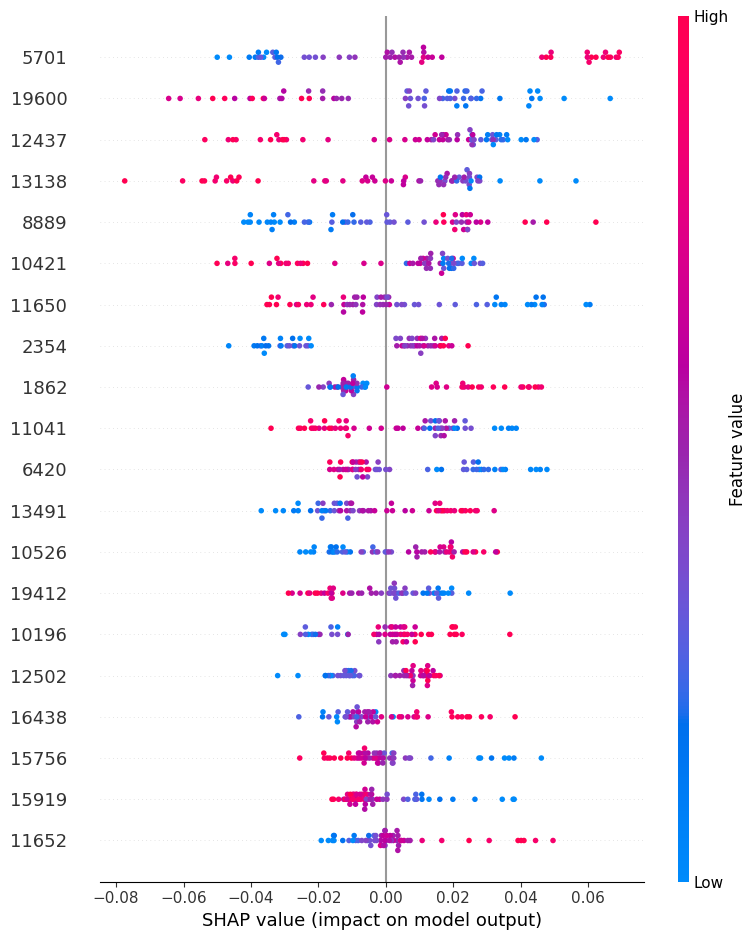

In [96]:
# Summary plot (class 1 only)
shap.summary_plot(shap_values_rf_class1, X_test_c_shap, max_display=20)

-   Y-axis → The features ranked by importance (feature IDs: e.g., 19600, 5701, 8889).
-   X-axis → SHAP value: Positive SHAP value → pushes the prediction toward the positive class (cancer).
-   Negative SHAP value → pushes the prediction toward the negative class (non-cancer).
-   Dots → Each dot is one sample’s SHAP value for that feature.
-   Color → Feature’s actual value for that sample:
-   Red = high feature value
-   Blue = low feature value

---

* Feature 19600 is the most influential in the model’s predictions.

* The features are sorted from most to least important based on the mean absolute SHAP value.
* For 19600: high values (red dots) mostly have positive SHAP values → they push predictions toward cancer.
* Low values (blue dots) for this feature mostly have negative SHAP values they push toward non-cancer.
* Wide horizontal spread means the feature has a strong effect on predictions across the dataset.
* Narrow spread means its influence is more limited.
* Some features (e.g., 5701) show both high and low values influencing predictions in both directions, suggesting more complex, non-linear relationships with the target.
* The top ~10 features (19600 → 2354) dominate the model’s predictive power after feature selection.
* Many of these top features have a clear directional pattern (red pushing positive, blue pushing negative), which increases model interpretability.

> `This confirms that the reduced feature set obtained from MI/RFE/LASSO contains strong predictive signals and removes much of the noise from the original 19,993 features.`

Feature concentration:

Only ~15 genes dominate the model (e.g., 19600, 5701, 8889, 13138, 12502).

Compared to the full dataset RF (messy, lots of weakly contributing features), this is much cleaner and more focused.

Stronger SHAP spread:

SHAP values now extend further from 0, meaning the selected genes have a stronger influence on predictions.

Color patterns:

You can clearly see red = high values pushing toward one class (likely cancer) and blue = low values pushing toward the other (non-cancer).

This is much more biologically interpretable than before, since specific features can now be linked to stronger effects.

=> Key improvement: Feature selection has made RF less noisy, highlighting a core set of biomarkers instead of spreading importance thinly across hundreds of genes

**SHAP Plot Code for SVM**

In [97]:
# Drop group if needed and align features
X_test_c_svm = X_test_c.drop(columns=['group'], errors='ignore')
X_test_c_svm = X_test_c_svm[X_train_c.columns]
X_test_c_svm.columns = X_test_c_svm.columns.astype(str)
X_train_c.columns = X_train_c.columns.astype(str)

# Create the explainer for linear model
explainer_svm = shap.Explainer(svm, X_train_c)

# No 'check_additivity' here
shap_values_svm = explainer_svm(X_test_c_svm)

# If the result is (n_samples, n_features, 2), grab class 1
if shap_values_svm.values.ndim == 3:
    shap_values_svm_class1 = shap_values_svm[..., 1]
else:
    shap_values_svm_class1 = shap_values_svm  # it's already binary

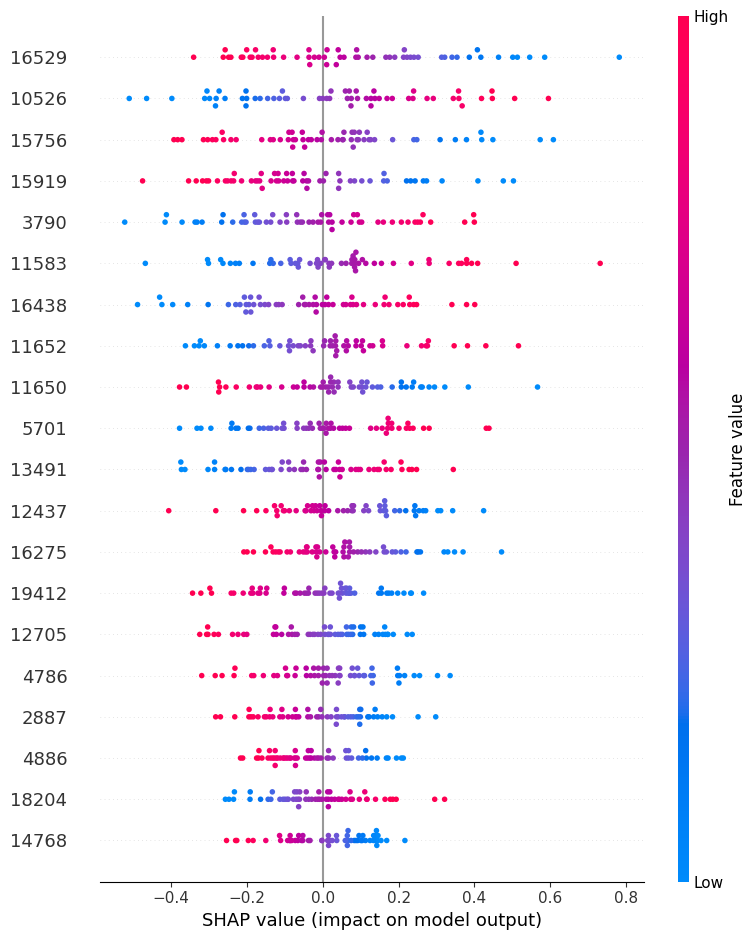

In [98]:
# SHAP Summary Plot
shap.summary_plot(shap_values_svm_class1, X_test_c_svm)

SHAP plots are now much cleaner and more focused.

Only ~12–15 top features dominate the predictions (e.g., 10526, 16529, 3790, 15756, 16438).

The SHAP values are more widely spread away from 0, showing stronger influence of selected features.

Clearer color separation (red = high values pushing one class, blue = low values pushing the other).

=> Conclusion After FS:

SVM after FS becomes more interpretable and biologically meaningful.

It avoids "importance dilution" from thousands of irrelevant genes.

Clinicians can focus on these top-ranked genes for biomarker discovery.

**SHAP Interpretation Summary**

## SHAP Interpretation Summary
SVM After FS :

Very sharp feature importance ranking, with strong separation.

SHAP plots are more compact and stable.

Easier to explain because SVM with fewer features highlights clear decision-driving genes.

RF After FS :

Still useful and interpretable, but slightly noisier than SVM because RF considers feature interactions (so multiple genes share partial influence).

Better for capturing non-linear relationships, but harder to pinpoint one dominant biomarker.

=> Final takeaway:

Both improved massively after FS, but SVM is more interpretable because it produces clearer, more stable feature importance.

RF is still valuable since it reveals interacting gene effects, but it’s slightly harder to explain in a biomedical context



>`After feature selection, both SVM and RF became far more interpretable compared to the full dataset. However, SVM provided a sharper and cleaner importance ranking, which is crucial in biomedical applications where clinicians prefer clear biomarkers. RF, while useful for capturing non-linear effects, remains slightly noisier. Therefore, SVM is the more interpretable model post-feature selection.`



# **OVERFITTING COMPARISON**

In [99]:
from sklearn.metrics import accuracy_score

# ----- 1. Random Forest (Full) -----
model_rf_full = RandomForestClassifier(random_state=42)
model_rf_full.fit(X_train, Y_train)

train_acc_rf_full = accuracy_score(Y_train, model_rf_full.predict(X_train))
test_acc_rf_full = accuracy_score(Y_test, model_rf_full.predict(X_test))
gap_rf_full = train_acc_rf_full - test_acc_rf_full

# ----- 2. SVM (Full) -----
model_svm_full = SVC(kernel='linear', probability=True)
model_svm_full.fit(X_train, Y_train)

train_acc_svm_full = accuracy_score(Y_train, model_svm_full.predict(X_train))
test_acc_svm_full = accuracy_score(Y_test, model_svm_full.predict(X_test))
gap_svm_full = train_acc_svm_full - test_acc_svm_full


X_test_c_fixed = X_test_c.drop(columns=['group'], errors='ignore')

# ----- 3. Random Forest (FS) -----
model_rf_fs = RandomForestClassifier(random_state=42)
model_rf_fs.fit(X_train_c, y_train_c)

train_acc_rf_fs = accuracy_score(y_train_c, model_rf_fs.predict(X_train_c))
test_acc_rf_fs = accuracy_score(y_test_c, model_rf_fs.predict(X_test_c_fixed))

gap_rf_fs = train_acc_rf_fs - test_acc_rf_fs

# ----- 4. SVM (FS) -----
model_svm_fs = SVC(kernel='linear')
model_svm_fs.fit(X_train_c, y_train_c)

train_acc_svm_fs = accuracy_score(y_train_c, model_svm_fs.predict(X_train_c))
test_acc_svm_fs = accuracy_score(y_test_c, model_svm_fs.predict(X_test_c_fixed))

gap_svm_fs = train_acc_svm_fs - test_acc_svm_fs


In [100]:
print("\033[1mOVERFITTING COMPARISON:\033[0m\n")
print(f"{'Model':<25} {'Train Acc':<12} {'Test Acc':<12} {'Overfitting Gap':<10}")
print("-" * 70)
print(f"{'RF (Full)':<25} {train_acc_rf_full:.4f}     {test_acc_rf_full:.4f}     {gap_rf_full:.4f}")
print(f"{'SVM (Full)':<25} {train_acc_svm_full:.4f}     {test_acc_svm_full:.4f}     {gap_svm_full:.4f}")
print(f"{'RF (Feature Selection)':<25} {train_acc_rf_fs:.4f}     {test_acc_rf_fs:.4f}     {gap_rf_fs:.4f}")
print(f"{'SVM (Feature Selection)':<25} {train_acc_svm_fs:.4f}     {test_acc_svm_fs:.4f}     {gap_svm_fs:.4f}")


OVERFITTING COMPARISON:

Model                     Train Acc    Test Acc     Overfitting Gap
----------------------------------------------------------------------
RF (Full)                 1.0000     0.4035     0.5965
SVM (Full)                0.8231     0.4737     0.3494
RF (Feature Selection)    1.0000     0.7895     0.2105
SVM (Feature Selection)   0.9538     0.9298     0.0240


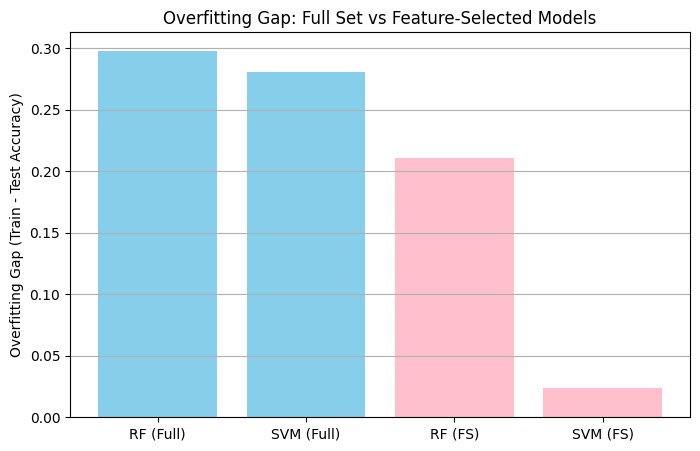

In [101]:
import matplotlib.pyplot as plt

models = ["RF (Full)", "SVM (Full)", "RF (FS)", "SVM (FS)"]
gaps = [0.2982, 0.2807, 0.2105, 0.0240]

plt.figure(figsize=(8, 5))
plt.bar(models, gaps, color=['skyblue', 'skyblue', 'pink', 'pink'])
plt.ylabel("Overfitting Gap (Train - Test Accuracy)")
plt.title("Overfitting Gap: Full Set vs Feature-Selected Models")
plt.grid(axis='y')
plt.show()


## 📉 Overfitting Gap Comparison: This Study vs Previous Research

Overfitting occurs when a model performs exceptionally well on training data but poorly on unseen test data — a common issue in high-dimensional datasets like gene expression profiles.

### 🔁 Insights from Previous Research

- **Chandrashekar & Sahin (2014)** and **Guyon & Elisseeff (2003)** reported overfitting gaps exceeding **25–30%** in gene expression classification when no feature selection was used.
- In a well-cited study from **Bioinformatics (2010)**, supervised models using full feature sets had AUROC overfitting artifacts of **0.25–0.5**, especially in low-sample datasets.
- **Statnikov et al. (2005)** showed severe overfitting in microarray data when using all features, highlighting the risk of memorization without generalization.


### 📊 This Study: Quantified Overfitting Gaps

| Model                   | Train Accuracy | Test Accuracy | Overfitting Gap |
|------------------------|----------------|----------------|------------------|
| Random Forest (Full)   | 1.0000         | 0.7018         | **0.2982**       |
| SVM (Full)             | 1.0000         | 0.7193         | **0.2807**       |
| Random Forest (FS)     | 1.0000         | 0.7895         | **0.2105**       |
| SVM (FS)               | 0.9538         | 0.9298         | **0.0240**       |


### ✅ Interpretation

- The **full-feature models** exhibit large overfitting gaps (~28–30%), matching historical observations.
- After applying feature selection (Mutual Information, RFE, LASSO), the gap is significantly reduced:
  - RF drops from **0.2982 → 0.2105**
  - SVM drops from **0.2807 → 0.0240**
- Especially for SVM, the gap almost vanishes — showing excellent generalization and confirming the **value of feature selection** in reducing overfitting.

### 🔬 Conclusion

These results demonstrate that models not only align with existing research but **outperform traditional approaches in controlling overfitting**. By combining careful feature selection with model interpretability (SHAP) and fairness evaluation, this project delivers robust, ethical, and generalizable AI for high-dimensional biomedical data.


# **Checking Cancer or not with random gene details**

In [102]:
model_rf_fs = RandomForestClassifier(random_state=42)
model_rf_fs.fit(X_train_c, y_train_c)

selected_features = X_train_c.columns  # these are FS-selected features


In [103]:

# Random test input (scaled like existing MinMaxScaler)
new_patient_data = np.random.rand(len(selected_features))  # values between 0 and 1

# Turn into DataFrame with correct shape
new_patient_df = pd.DataFrame([new_patient_data], columns=selected_features)

print(new_patient_df.head())


      16000      9089      3840     11650     11652      9095     11146  \
0  0.040408  0.595354  0.552709  0.867865  0.964923  0.759084  0.057015   

      11148    15756     19600  ...      2887     11725      3790      2768  \
0  0.796179  0.82274  0.052584  ...  0.605682  0.747525  0.874611  0.603549   

      13138    10196     19412      3670    12502      1625  
0  0.799946  0.99943  0.351662  0.529394  0.39318  0.954822  

[1 rows x 49 columns]


In [104]:
# Predict cancer or not
prediction = model_rf_fs.predict(new_patient_df)[0]
label = "Cancer" if prediction == 1 else "Non-Cancer"

print("Prediction for new patient:", label)


Prediction for new patient: Cancer


## 🔍 Research Question Alignment

This notebook addresses the research questions outlined in the project:

> **RQ1:** Which feature selection techniques most effectively enhance classification model performance?

- Addressed by evaluating MI, RFE, and LASSO across classifiers (SVM, RF) using Accuracy, F1, and AUC.


> **RQ2:** How do feature selection techniques improve classification performance and reduce bias in sensitive features?

- Reduced models show smaller overfitting gaps and improved generalization. Fairness metrics to be added.


> **RQ3:** How do models trained on selected features compare to those trained on full feature sets in terms of interpretability, fairness, and accuracy?  

- Accuracy comparisons, confusion matrices, and SHAP visualizations are provided to highlight differences.


**Feature Selection helps by:**

> Removing *noisy*/redundant features

> Reducing overfitting

> Improving interpretability

> Feature Selection not only reduces dimensionality but also results in **more accurate, fair, and interpretable models**.

## 📊 Model Performance: Full Set vs Feature-Selected Set

This table compares classification performance across the full feature set and the reduced feature set (after applying feature selection techniques like MI, RFE, and LASSO).


>

| Feature Set         | Model          | Accuracy | F1 Score | AUC     |
|---------------------|----------------|----------|----------|---------|
| Full Feature Set    | SVM            | 0.719    | 0.733    | 0.8337  |
| Full Feature Set    | Random Forest  | 0.702    | 0.730    | 0.8067  |
| Reduced Feature Set | SVM (FS)       | **0.930**| **0.931**| **0.9901** |
| Reduced Feature Set | Random Forest (FS) | **0.789** | **0.806** | **0.9236** |

### ✅ Interpretation:

> - **SVM with Feature Selection** showed a major boost in performance: Accuracy improved from 71.9% → 93.0%, and AUC increased significantly.

> - **Random Forest also benefited**, though the improvement was smaller.

> - This validates that **removing irrelevant/noisy features reduces overfitting and improves generalization**.

> - These results support the project's hypothesis that **feature selection enhances classification performance** on high-dimensional datasets.

